In [7]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!pip install ipywidgets
!pip install tensorboard

In [9]:
import pandas as pd
import numpy as np
import random
import joblib
import torch

from sklearn import preprocessing
from sklearn import model_selection
# from DataAugmentation 
from DataAugmentation import DataAugmentation
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import config
from transformers import XLMRobertaForTokenClassification, XLMRobertaConfig ,BertModel, XLMRobertaTokenizer, XLMRobertaModel, BertForTokenClassification
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders
from seqeval.metrics import accuracy_score, classification_report,f1_score
from sklearn.metrics import matthews_corrcoef,classification_report
import engine
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

In [10]:
import matplotlib.pyplot as plt
def plot_against_epochs(matrix1,matrix2,label1 , label2 ,y_label , title, epochs):
    
    epochs = np.arange(1,epoch+1)
    plt.plot(epochs,matrix1,label=label1)
    if matrix2 is not None :
        plt.plot(epochs,matrix2,label=label2)
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

In [11]:
# import data_utils
# data_utils = reload(data_utils)
# from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders
# config = reload(config)

In [12]:
# config= reload(config)

In [13]:
#setting seed
def set_seed():
    
    torch.manual_seed(config.random_seed)
    np.random.seed(config.random_seed)
    random.seed(config.random_seed)
    torch.cuda.manual_seed(config.random_seed)
set_seed()    

In [14]:
import os
from torch.utils.tensorboard import SummaryWriter
from torch.utils.tensorboard.summary import hparams

class SummaryWriter(SummaryWriter):
    def add_hparams(self, hparam_dict, metric_dict):
        torch._C._log_api_usage_once("tensorboard.logging.add_hparams")
        if type(hparam_dict) is not dict or type(metric_dict) is not dict:
            raise TypeError('hparam_dict and metric_dict should be dictionary.')
        exp, ssi, sei = hparams(hparam_dict, metric_dict)

        logdir = self._get_file_writer().get_logdir()
        
        with SummaryWriter(log_dir=logdir) as w_hp:
            w_hp.file_writer.add_summary(exp)
            w_hp.file_writer.add_summary(ssi)
            w_hp.file_writer.add_summary(sei)
            for k, v in metric_dict.items():
                w_hp.add_scalar(k, v)

In [15]:
class EarlyStopping(object):
    def __init__(self, mode='max', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = 0
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best 
            if mode == 'max':
                self.is_better = lambda a, best: a > best 
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

In [16]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()
# outputs[0]

In [17]:
# config = reload(config)

<h3>Running for smaller datasets to check results </h3>

In [18]:
# Read the labelled data
def process_data_labelled(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags,
                 filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval,train_data_needed,
                 model_type='xlm'):
    
    
    set_seed()
    dataObjTrain = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
    df_train= dataObjTrain.createDf() # get dataframe from files of training data 
    dataObjEval = loadDatafromFile(filePath_src_eval,filePath_tar_eval, filePath_srcTags_eval,filePath_tarTags_eval)
    df_eval = dataObjEval.createDf() # get dataframe from files of validation data
#     df_combined = df_train.append(df_eval, ignore_index=True)
#     df_combined.reset_index(drop=True)
    split_ratio_len = int(len(df_train) - config.test_split_ratio*len(df_train)) # 7000 - 1400
    df_train_splitted = df_train.iloc[:split_ratio_len,:] # select rows till the split_len : 5600
    df_eval_splitted = df_train.iloc[split_ratio_len:,:] # select everything after split_len : 5600
    df_train_splitted = df_train_splitted[:train_data_needed] # amount of data needed for training 
    eval_data_needed = int(0.25 * train_data_needed) # 25 % reserve for validation
    df_eval_splitted = df_eval_splitted[:eval_data_needed] # select eval_data from the splitted eval df
    obj_tokenized_train = createTokenizedDf(df_train_splitted,model_type) # tokenize all 3 dataframes  tr,eval,test
    obj_tokenized_val = createTokenizedDf(df_eval_splitted,model_type)
    obj_tokenized_test = createTokenizedDf(df_eval,model_type)
    df_new_train = obj_tokenized_train.convertDf()# conver to tokenized df
    df_new_eval = obj_tokenized_val.convertDf()
    df_new_test = obj_tokenized_test.convertDf()
    train_data = CompDataset(df_new_train,model_type) # create tuple of tensors
    eval_data = CompDataset(df_new_eval,model_type)
    test_data = CompDataset(df_new_test,model_type)
    return train_data,eval_data, test_data


In [ ]:
train_data , eval_data, test_data = process_data_labelled(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags,config.filePath_src_eval,config.filePath_tar_eval, config.filePath_srcTags_eval,config.filePath_tarTags_eval,1000 )

In [ ]:
print(len(train_data))
print(len(eval_data))
print(len(test_data))

In [ ]:
print(next(iter(train_data))[0]) # 0,17151,12456,..
print(next(iter(eval_data))[0])#121220

In [68]:
# dataloaders
loader_obj = createDataloaders(train_data,config.TRAIN_BATCH_SIZE)
train_dataloader = loader_obj.createDataloaders()
print(len(train_dataloader))
loader_obj = createDataloaders(eval_data,config.VALID_BATCH_SIZE)
val_dataloader = loader_obj.createDataloaders()
print(len(val_dataloader))
loader_obj = createDataloaders(test_data,config.VALID_BATCH_SIZE)
test_dataloader = loader_obj.createDataloaders()
print(len(test_dataloader))

125
32
125


In [69]:
batch = next(iter(train_dataloader))
print(batch[0])
print(batch[2])


tensor([[     0,  23865, 199668,  ...,      1,      1,      1],
        [     0,  52185,  34053,  ...,      1,      1,      1],
        [     0,  16545,   9136,  ...,      1,      1,      1],
        ...,
        [     0,   9563,    237,  ...,      1,      1,      1],
        [     0,  24372,   1919,  ...,      1,      1,      1],
        [     0,  24372,     70,  ...,      1,      1,      1]])
tensor([[-100,    1,    1,  ..., -100, -100, -100],
        [-100,    1,    1,  ..., -100, -100, -100],
        [-100,    1,    1,  ..., -100, -100, -100],
        ...,
        [-100,    1,    1,  ..., -100, -100, -100],
        [-100,    1,    1,  ..., -100, -100, -100],
        [-100,    1,    1,  ..., -100, -100, -100]])


In [ ]:
class EntityModel(nn.Module):
    
    def __init__(self,dropout=0.3): # dropout can be passed here
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaModel.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
        self.dropout = dropout
        self.bert_drop_1 = nn.Dropout(self.dropout)
        self.out_tag = nn.Linear(768, 2)
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, ids, attention_mask):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                return_dict=False)
        bo_tag = self.bert_drop_1(outputs[0])
        
        tag = self.out_tag(bo_tag)  
        softmax_prob = self.softmax(tag)
        
#         loss_tag = ClassificationCost(outputs[0],labels,attention_mask)
        
#         return bo_tag,loss
        return softmax_prob, tag
        

In [89]:
# set_seed()
# model = EntityModel()
# model.cuda()
# model.load_state_dict(torch.load('../models/MeanTeacher_models/StudentModels/studentModel_v1_rampup_const_cost_600_steps_to_1_withDropout_1000_labeled_1000_unlabeled_newTest_data_retest.bin'))
# test_results = engine.eval_fn(test_dataloader,model)

In [90]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(train_data) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
early_stopping = EarlyStopping(patience=8)

/opt/conda/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [91]:
config.MAX_LEN

128

In [92]:
writer = SummaryWriter("runs/SupervisedTraining/with_1000_labelled_withdropout_less_seq_len_retest")
set_seed()
best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta_verylessData_wl_1000_less_seq_len.txt_retest', 'w') as f:
    f.write('metrics_xlmroberta_lessData_wl_(1000)_less_seq_len_retest'+'\n')
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[21],train_metrics[22]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[21],test_metrics[22]))
            print('For gaps : ',classification_report(test_metrics[27],test_metrics[28]) )
            print('For tar :',classification_report(test_metrics[25],test_metrics[26]) )
            print('For source : ',classification_report(test_metrics[23],test_metrics[24]) )
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            writer.add_scalar('Train_loss',train_metrics[0], epoch)
            writer.add_scalar('Validation_loss',test_metrics[0],epoch)
            writer.add_scalar('mcc_score/Test',test_metrics[4],epoch)
            writer.add_scalar('mcc_score/Train',train_metrics[4],epoch)
            train_loss_lst.append(train_metrics[:-14])
            val_loss_lst.append(test_metrics[:-14])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            writer.add_hparams(
                    { "lr": float(config.lr),  
                     "train_data": float(len(train_dataloader)*config.TRAIN_BATCH_SIZE), 
                     "validation_data":float(len(val_dataloader)*config.TRAIN_BATCH_SIZE) 
                    },
                    {
                    "train_loss": float(train_metrics[0]),
                    "test_loss" : float(test_metrics[0]),
                    "mcc_score_test" : float(test_metrics[4])
                    },
                )
            if early_stopping.step(float("{:.3f}".format(test_metrics[4]))): #mcc score for early stopping "{:.2f}".format(a_float)
                  break  # early stop criterion is met, we can stop now
            if float("{:.3f}".format(test_metrics[4])) >  best_accuracy:
                torch.save(model.state_dict(), '../models/training_data/labeled_1000_data_less_seq_len_retest.bin')
                best_accuracy = float("{:.3f}".format(test_metrics[4]))
                print('Model saved for this epoch!')
    writer.flush()
    writer.close()

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 of 25


/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/32 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.32474084946335197
Average F1 Training score for class 1 : 0.7024536157484135
Average Accuracy Training score  : 0.5869248035914703
Average mcc Training score  : 0.21984268695650527
Average F1 Training score for source sentence class 0 : 0.3071057926506407
Average F1 Training score for source sentence class 1 : 0.6104661546704768
Average Accuracy Training score source sentence  : 0.5012957317073171
Average mcc Training score source sentence : 0.15862057377214062
Average F1 Training score for target sentence class 0 : 0.35073999327278843
Average F1 Training score for target sentence class 1 : 0.510616720542562
Average Accuracy Training score target sentence  : 0.441902490151433
Average mcc Training score target sentence : 0.15436131636300315
Average F1 Training score for gaps in target sentence class 0 : 0.019271948608137045
Average F1 Training score for gaps in target sentence class 1 : 0.9729058211074302
Average Accuracy Training score gaps in 

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 32/32 [00:01<00:00, 16.02it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning

Average F1 Validation score for whole sentence class 0 : 0.3570087918601206
Average F1 Validation score for whole sentence class 1 : 0.7358038722247027
Average Accuracy Validation score whole sentence  : 0.6254890678941312
Average mcc Validation score whole sentence : 0.27542884399242873
Average F1 Validation score for source sentence class 0 : 0.34782608695652173
Average F1 Validation score for source sentence class 1 : 0.6555023923444977
Average Accuracy Validation score source sentence  : 0.5491546649968692
Average mcc Validation score source sentence : 0.23221150357860862
Average F1 Validation score for target sentence class 0 : 0.37133666904932094
Average F1 Validation score for target sentence class 1 : 0.5570385293376983
Average Accuracy Validation score target sentence  : 0.48027773674102525
Average mcc Validation score target sentence : 0.21865503593244073
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sente

  0%|          | 0/125 [00:00<?, ?it/s]

Model saved for this epoch!
Epoch 2 of 25


/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/32 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.3983013456871829
Average F1 Training score for class 1 : 0.7947241664785129
Average Accuracy Training score  : 0.6938832772166106
Average mcc Training score  : 0.32048552298643823
Average F1 Training score for source sentence class 0 : 0.3849922640536359
Average F1 Training score for source sentence class 1 : 0.7419389742479984
Average Accuracy Training score source sentence  : 0.6364329268292683
Average mcc Training score source sentence : 0.28260093664222086
Average F1 Training score for target sentence class 0 : 0.4191628645110097
Average F1 Training score for target sentence class 1 : 0.667026781145164
Average Accuracy Training score target sentence  : 0.5767103979182479
Average mcc Training score target sentence : 0.2789211586343343
Average F1 Training score for gaps in target sentence class 0 : 0.034013605442176874
Average F1 Training score for gaps in target sentence class 1 : 0.9833694442817825
Average Accuracy Training score gaps in ta

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 32/32 [00:02<00:00, 15.90it/s]


Average F1 Validation score for whole sentence class 0 : 0.41733793632527805
Average F1 Validation score for whole sentence class 1 : 0.8308400460299196
Average Accuracy Validation score whole sentence  : 0.7378020713463751
Average mcc Validation score whole sentence : 0.337582897233113
Average F1 Validation score for source sentence class 0 : 0.40325392213829175
Average F1 Validation score for source sentence class 1 : 0.7799442896935933
Average Accuracy Validation score source sentence  : 0.6784596117720726
Average mcc Validation score source sentence : 0.29830579052004214
Average F1 Validation score for target sentence class 0 : 0.44027223656418685
Average F1 Validation score for target sentence class 1 : 0.7429125794976824
Average Accuracy Validation score target sentence  : 0.6476584429014626
Average mcc Validation score target sentence : 0.3125411383216722
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence

  0%|          | 0/125 [00:00<?, ?it/s]

Model saved for this epoch!
Epoch 3 of 25


/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/32 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.4622999091564076
Average F1 Training score for class 1 : 0.8448529876985096
Average Accuracy Training score  : 0.75918911335578
Average mcc Training score  : 0.3983104240098501
Average F1 Training score for source sentence class 0 : 0.44885406751116647
Average F1 Training score for source sentence class 1 : 0.8061200834556834
Average Accuracy Training score source sentence  : 0.7131478658536585
Average mcc Training score source sentence : 0.3676086860791409
Average F1 Training score for target sentence class 0 : 0.48691604700005675
Average F1 Training score for target sentence class 1 : 0.7603722064632433
Average Accuracy Training score target sentence  : 0.6733167082294265
Average mcc Training score target sentence : 0.3776180594741445
Average F1 Training score for gaps in target sentence class 0 : 0.07704160246533129
Average F1 Training score for gaps in target sentence class 1 : 0.982430410934796
Average Accuracy Training score gaps in targe

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/125 [00:00<?, ?it/s]

Average F1 Validation score for whole sentence class 0 : 0.426441351888668
Average F1 Validation score for whole sentence class 1 : 0.8794736109176995
Average Accuracy Validation score whole sentence  : 0.8008055235903337
Average mcc Validation score whole sentence : 0.3326699480551635
Average F1 Validation score for source sentence class 0 : 0.4023346303501946
Average F1 Validation score for source sentence class 1 : 0.8495002939447384
Average Accuracy Validation score source sentence  : 0.7595491546649968
Average mcc Validation score source sentence : 0.2827148879695628
Average F1 Validation score for target sentence class 0 : 0.46418857660924756
Average F1 Validation score for target sentence class 1 : 0.8266692736337863
Average Accuracy Validation score target sentence  : 0.7380706160437288
Average mcc Validation score target sentence : 0.33226400238168075
Average F1 Validation score for gaps in target sentence class 0 : 0.025477707006369428
Average F1 Validation score for gaps in 

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/32 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.5296464250400628
Average F1 Training score for class 1 : 0.8781694059047435
Average Accuracy Training score  : 0.8064674523007856
Average mcc Training score  : 0.4795939434204017
Average F1 Training score for source sentence class 0 : 0.5147220910092899
Average F1 Training score for source sentence class 1 : 0.8450399718437328
Average Accuracy Training score source sentence  : 0.7650914634146342
Average mcc Training score source sentence : 0.4542363149673717
Average F1 Training score for target sentence class 0 : 0.5634053367217281
Average F1 Training score for target sentence class 1 : 0.8264558816101825
Average Accuracy Training score target sentence  : 0.7516354042430157
Average mcc Training score target sentence : 0.4794383619523937
Average F1 Training score for gaps in target sentence class 0 : 0.14430665163472378
Average F1 Training score for gaps in target sentence class 1 : 0.9775808595480727
Average Accuracy Training score gaps in targ

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/125 [00:00<?, ?it/s]

Average F1 Validation score for whole sentence class 0 : 0.4123711340206186
Average F1 Validation score for whole sentence class 1 : 0.8911620294599017
Average Accuracy Validation score whole sentence  : 0.8163406214039125
Average mcc Validation score whole sentence : 0.31499679726637686
Average F1 Validation score for source sentence class 0 : 0.38886509635974303
Average F1 Validation score for source sentence class 1 : 0.8633272675031127
Average Accuracy Validation score source sentence  : 0.7766123982467126
Average mcc Validation score source sentence : 0.26730726799714843
Average F1 Validation score for target sentence class 0 : 0.4472259810554804
Average F1 Validation score for target sentence class 1 : 0.8455868455868456
Average Accuracy Validation score target sentence  : 0.7586054070025114
Average mcc Validation score target sentence : 0.31066573425187005
Average F1 Validation score for gaps in target sentence class 0 : 0.07092198581560283
Average F1 Validation score for gaps i

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/32 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.5933253695684635
Average F1 Training score for class 1 : 0.9059012541892686
Average Accuracy Training score  : 0.8471661054994388
Average mcc Training score  : 0.5502090752198625
Average F1 Training score for source sentence class 0 : 0.581916470485657
Average F1 Training score for source sentence class 1 : 0.883080149228256
Average Accuracy Training score source sentence  : 0.8172637195121951
Average mcc Training score source sentence : 0.531366808953017
Average F1 Training score for target sentence class 0 : 0.6365995651259031
Average F1 Training score for target sentence class 1 : 0.8738833037170467
Average Accuracy Training score target sentence  : 0.8127507318659872
Average mcc Training score target sentence : 0.5694225724340001
Average F1 Training score for gaps in target sentence class 0 : 0.13559322033898308
Average F1 Training score for gaps in target sentence class 1 : 0.9727434679334918
Average Accuracy Training score gaps in target 

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/125 [00:00<?, ?it/s]

Average F1 Validation score for whole sentence class 0 : 0.42143401983218914
Average F1 Validation score for whole sentence class 1 : 0.8972082938067489
Average Accuracy Validation score whole sentence  : 0.8254315304948217
Average mcc Validation score whole sentence : 0.3266383062550095
Average F1 Validation score for source sentence class 0 : 0.4012427873945851
Average F1 Validation score for source sentence class 1 : 0.8718046184548133
Average Accuracy Validation score source sentence  : 0.7888227927363807
Average mcc Validation score source sentence : 0.2841128993942629
Average F1 Validation score for target sentence class 0 : 0.457263454097784
Average F1 Validation score for target sentence class 1 : 0.8557269752220664
Average Accuracy Validation score target sentence  : 0.7720490471266066
Average mcc Validation score target sentence : 0.3254055307556104
Average F1 Validation score for gaps in target sentence class 0 : 0.04054054054054054
Average F1 Validation score for gaps in ta

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/32 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.6462509865824784
Average F1 Training score for class 1 : 0.923528408121481
Average Accuracy Training score  : 0.8742424242424243
Average mcc Training score  : 0.6096262745160443
Average F1 Training score for source sentence class 0 : 0.6365655070318283
Average F1 Training score for source sentence class 1 : 0.9057400652716452
Average Accuracy Training score source sentence  : 0.8503048780487805
Average mcc Training score source sentence : 0.5947494108805581
Average F1 Training score for target sentence class 0 : 0.6877041877041877
Average F1 Training score for target sentence class 1 : 0.8995462144733699
Average Accuracy Training score target sentence  : 0.8479887238425675
Average mcc Training score target sentence : 0.6311300263220103
Average F1 Training score for gaps in target sentence class 0 : 0.21992481203007516
Average F1 Training score for gaps in target sentence class 1 : 0.9753548310469743
Average Accuracy Training score gaps in targe

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/125 [00:00<?, ?it/s]

Average F1 Validation score for whole sentence class 0 : 0.37566271143650587
Average F1 Validation score for whole sentence class 1 : 0.9197051852332868
Average Accuracy Validation score whole sentence  : 0.8577100115074798
Average mcc Validation score whole sentence : 0.2996223906043324
Average F1 Validation score for source sentence class 0 : 0.3568129330254041
Average F1 Validation score for source sentence class 1 : 0.8991307497283592
Average Accuracy Validation score source sentence  : 0.8256105197244834
Average mcc Validation score source sentence : 0.2575216782838073
Average F1 Validation score for target sentence class 0 : 0.4115694642010431
Average F1 Validation score for target sentence class 1 : 0.8914165718785546
Average Accuracy Validation score target sentence  : 0.8166642044615158
Average mcc Validation score target sentence : 0.3080996810873046
Average F1 Validation score for gaps in target sentence class 0 : 0.016666666666666666
Average F1 Validation score for gaps in 

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/32 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.6882005045700815
Average F1 Training score for class 1 : 0.9363157939196324
Average Accuracy Training score  : 0.8942340067340068
Average mcc Training score  : 0.6552800953456132
Average F1 Training score for source sentence class 0 : 0.6796608517688335
Average F1 Training score for source sentence class 1 : 0.9221440583623487
Average Accuracy Training score source sentence  : 0.8747332317073171
Average mcc Training score source sentence : 0.6423872501291936
Average F1 Training score for target sentence class 0 : 0.7377861694595232
Average F1 Training score for target sentence class 1 : 0.9218101203462595
Average Accuracy Training score target sentence  : 0.879540279735444
Average mcc Training score target sentence : 0.689666673442711
Average F1 Training score for gaps in target sentence class 0 : 0.23860811930405965
Average F1 Training score for gaps in target sentence class 1 : 0.9725957954376026
Average Accuracy Training score gaps in target

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/125 [00:00<?, ?it/s]

Average F1 Validation score for whole sentence class 0 : 0.3848797250859106
Average F1 Validation score for whole sentence class 1 : 0.9116631024839612
Average Accuracy Validation score whole sentence  : 0.845512082853855
Average mcc Validation score whole sentence : 0.2966494916417813
Average F1 Validation score for source sentence class 0 : 0.3674121405750798
Average F1 Validation score for source sentence class 1 : 0.8909891723251974
Average Accuracy Validation score source sentence  : 0.8140262993112085
Average mcc Validation score source sentence : 0.25842936686097695
Average F1 Validation score for target sentence class 0 : 0.42209753992231336
Average F1 Validation score for target sentence class 1 : 0.8806701719989305
Average Accuracy Validation score target sentence  : 0.8021864381740287
Average mcc Validation score target sentence : 0.3029306979458099
Average F1 Validation score for gaps in target sentence class 0 : 0.07058823529411765
Average F1 Validation score for gaps in t

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/32 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.7193159801196193
Average F1 Training score for class 1 : 0.9439142217509132
Average Accuracy Training score  : 0.9065095398428732
Average mcc Training score  : 0.6911065532143578
Average F1 Training score for source sentence class 0 : 0.712478836769246
Average F1 Training score for source sentence class 1 : 0.9319729494097411
Average Accuracy Training score source sentence  : 0.8899771341463415
Average mcc Training score source sentence : 0.6809607475097883
Average F1 Training score for target sentence class 0 : 0.7738441642418364
Average F1 Training score for target sentence class 1 : 0.9348787413303543
Average Accuracy Training score target sentence  : 0.8988759984097727
Average mcc Training score target sentence : 0.7333283480356465
Average F1 Training score for gaps in target sentence class 0 : 0.2633559066967645
Average F1 Training score for gaps in target sentence class 1 : 0.9707000269356238
Average Accuracy Training score gaps in target

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/125 [00:00<?, ?it/s]

Average F1 Validation score for whole sentence class 0 : 0.37835129040340765
Average F1 Validation score for whole sentence class 1 : 0.9193668952517143
Average Accuracy Validation score whole sentence  : 0.8572497123130034
Average mcc Validation score whole sentence : 0.3014346811601035
Average F1 Validation score for source sentence class 0 : 0.36374337845791643
Average F1 Validation score for source sentence class 1 : 0.9024103999277783
Average Accuracy Validation score source sentence  : 0.8307764558547276
Average mcc Validation score source sentence : 0.2687688276722599
Average F1 Validation score for target sentence class 0 : 0.4125350795135641
Average F1 Validation score for target sentence class 1 : 0.8898245614035087
Average Accuracy Validation score target sentence  : 0.8144482198256758
Average mcc Validation score target sentence : 0.30630006441206636
Average F1 Validation score for gaps in target sentence class 0 : 0.06493506493506493
Average F1 Validation score for gaps in

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/32 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.7521815008726005
Average F1 Training score for class 1 : 0.9525242393848212
Average Accuracy Training score  : 0.920314253647587
Average mcc Training score  : 0.7263391730011027
Average F1 Training score for source sentence class 0 : 0.7479674796747967
Average F1 Training score for source sentence class 1 : 0.9436179639043044
Average Accuracy Training score source sentence  : 0.9078506097560975
Average mcc Training score source sentence : 0.7186050184884528
Average F1 Training score for target sentence class 0 : 0.8014663000916437
Average F1 Training score for target sentence class 1 : 0.9450098073151033
Average Accuracy Training score target sentence  : 0.9138747334562145
Average mcc Training score target sentence : 0.7651118027343254
Average F1 Training score for gaps in target sentence class 0 : 0.3356009070294784
Average F1 Training score for gaps in target sentence class 1 : 0.9736975971752596
Average Accuracy Training score gaps in target

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/125 [00:00<?, ?it/s]

Average F1 Validation score for whole sentence class 0 : 0.3747211895910781
Average F1 Validation score for whole sentence class 1 : 0.9178844589096826
Average Accuracy Validation score whole sentence  : 0.8548331415420023
Average mcc Validation score whole sentence : 0.29556032423298073
Average F1 Validation score for source sentence class 0 : 0.3575615474794842
Average F1 Validation score for source sentence class 1 : 0.9009936766034325
Average Accuracy Validation score source sentence  : 0.828428303068253
Average mcc Validation score source sentence : 0.2609013173157341
Average F1 Validation score for target sentence class 0 : 0.4139228598306679
Average F1 Validation score for target sentence class 1 : 0.8908166841920786
Average Accuracy Validation score target sentence  : 0.8159255429162358
Average mcc Validation score target sentence : 0.3091577988094842
Average F1 Validation score for gaps in target sentence class 0 : 0.1083743842364532
Average F1 Validation score for gaps in tar

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/32 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.7719345079195586
Average F1 Training score for class 1 : 0.9573132140834748
Average Accuracy Training score  : 0.9280864197530864
Average mcc Training score  : 0.7476667982071419
Average F1 Training score for source sentence class 0 : 0.7680835197613721
Average F1 Training score for source sentence class 1 : 0.9494813542802776
Average Accuracy Training score source sentence  : 0.9170350609756097
Average mcc Training score source sentence : 0.7404780641968226
Average F1 Training score for target sentence class 0 : 0.8273850377487989
Average F1 Training score for target sentence class 1 : 0.9539398379195092
Average Accuracy Training score target sentence  : 0.9272832411724312
Average mcc Training score target sentence : 0.7948010648419429
Average F1 Training score for gaps in target sentence class 0 : 0.34612700628053034
Average F1 Training score for gaps in target sentence class 1 : 0.9718694647092377
Average Accuracy Training score gaps in targ

/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 32/32 [00:02<00:00, 15.35it/s]


Average F1 Validation score for whole sentence class 0 : 0.3835616438356165
Average F1 Validation score for whole sentence class 1 : 0.9111257406188282
Average Accuracy Validation score whole sentence  : 0.8446490218642118
Average mcc Validation score whole sentence : 0.2947583976615114
Average F1 Validation score for source sentence class 0 : 0.36790393013100436
Average F1 Validation score for source sentence class 1 : 0.8941885964912281
Average Accuracy Validation score source sentence  : 0.8187226048841578
Average mcc Validation score source sentence : 0.2621631098540245
Average F1 Validation score for target sentence class 0 : 0.420597144093466
Average F1 Validation score for target sentence class 1 : 0.8807339449541284
Average Accuracy Validation score target sentence  : 0.8021864381740287
Average mcc Validation score target sentence : 0.30153670421494566
Average F1 Validation score for gaps in target sentence class 0 : 0.14345991561181434
Average F1 Validation score for gaps in t

In [21]:
model.load_state_dict(torch.load('../models/training_data/labeled_1000_data_test_less_seq_len_128.bin'))
model.eval()

In [75]:
# model.load_state_dict(torch.load('../models/MeanTeacher_models/TeacherModels/teacherModel_v1_rampup_const_cost_300_steps_to_1_withDropout_500_labeled_500_unlabeled_newTest_data.bin'))
# model.eval()
test_metrics = engine.eval_fn(test_dataloader, model)

  0%|          | 0/125 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:07<00:00, 17.03it/s]


Average F1 Validation score for whole sentence class 0 : 0.40981164553609856
Average F1 Validation score for whole sentence class 1 : 0.8382578403534395
Average Accuracy Validation score whole sentence  : 0.7460979777841071
Average mcc Validation score whole sentence : 0.3154017584054235
Average F1 Validation score for source sentence class 0 : 0.3957400833461954
Average F1 Validation score for source sentence class 1 : 0.7981022123665618
Average Accuracy Validation score source sentence  : 0.697332817935833
Average mcc Validation score source sentence : 0.2757835316596582
Average F1 Validation score for target sentence class 0 : 0.43192376414532463
Average F1 Validation score for target sentence class 1 : 0.7467608326253186
Average Accuracy Validation score target sentence  : 0.6496859734822051
Average mcc Validation score target sentence : 0.282020623439933
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence cl

In [76]:
model.load_state_dict(torch.load('../models/training_data/labeled_1000_data_test.bin'))
model.eval()
test_metrics = engine.eval_fn(test_dataloader, model)


  0%|          | 0/125 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:07<00:00, 17.31it/s]


Average F1 Validation score for whole sentence class 0 : 0.40290594934223445
Average F1 Validation score for whole sentence class 1 : 0.898690741912916
Average Accuracy Validation score whole sentence  : 0.8267729991455426
Average mcc Validation score whole sentence : 0.30431848836709635
Average F1 Validation score for source sentence class 0 : 0.386957017443849
Average F1 Validation score for source sentence class 1 : 0.8748632735227723
Average Accuracy Validation score source sentence  : 0.7921530730575956
Average mcc Validation score source sentence : 0.26721769032598464
Average F1 Validation score for target sentence class 0 : 0.4396767901922541
Average F1 Validation score for target sentence class 1 : 0.861903998901275
Average Accuracy Validation score target sentence  : 0.7784184816542403
Average mcc Validation score target sentence : 0.30404588843529323
Average F1 Validation score for gaps in target sentence class 0 : 0.0959232613908873
Average F1 Validation score for gaps in ta

In [72]:
model.load_state_dict(torch.load('../models/MeanTeacher_models/StudentModels/studentModel_v1_rampup_const_cost_300_steps_to_1_withDropout_500_labeled_500_unlabeled_newTest_data.bin'))
model.eval()
test_metrics = engine.eval_fn(test_dataloader, model)

  0%|          | 0/125 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:13<00:00,  9.23it/s]


Average F1 Validation score for whole sentence class 0 : 0.3986033519553073
Average F1 Validation score for whole sentence class 1 : 0.8462170318387172
Average Accuracy Validation score whole sentence  : 0.7550660542369989
Average mcc Validation score whole sentence : 0.2967336304509926
Average F1 Validation score for source sentence class 0 : 0.38351284878297004
Average F1 Validation score for source sentence class 1 : 0.8180430048311597
Average Accuracy Validation score source sentence  : 0.7190181677618863
Average mcc Validation score source sentence : 0.2549070579758502
Average F1 Validation score for target sentence class 0 : 0.42054535472457755
Average F1 Validation score for target sentence class 1 : 0.7512634528267302
Average Accuracy Validation score target sentence  : 0.651936535854311
Average mcc Validation score target sentence : 0.2622866775492271
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence c

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [61]:
test_metrics = engine.eval_fn(test_dataloader, model)

  0%|          | 0/125 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:13<00:00,  9.25it/s]


Average F1 Validation score for whole sentence class 0 : 0.4031038599283725
Average F1 Validation score for whole sentence class 1 : 0.8701433617286516
Average Accuracy Validation score whole sentence  : 0.7866924531789935
Average mcc Validation score whole sentence : 0.2990814602692344
Average F1 Validation score for source sentence class 0 : 0.3817147265888706
Average F1 Validation score for source sentence class 1 : 0.8450363781392763
Average Accuracy Validation score source sentence  : 0.752183996907615
Average mcc Validation score source sentence : 0.2529324970256736
Average F1 Validation score for target sentence class 0 : 0.43145753233135276
Average F1 Validation score for target sentence class 1 : 0.7980733421059165
Average Accuracy Validation score target sentence  : 0.7019896669231614
Average mcc Validation score target sentence : 0.2768279993947135
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence cl

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [23]:
model.load_state_dict(torch.load('../models/training_data/labeled_2000_data_test.bin'))
model.eval()
test_metrics = engine.eval_fn(test_dataloader, model)

  0%|          | 0/125 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:13<00:00,  9.01it/s]


Average F1 Validation score for whole sentence class 0 : 0.4382072005878031
Average F1 Validation score for whole sentence class 1 : 0.9046054546815607
Average Accuracy Validation score whole sentence  : 0.8369050497006584
Average mcc Validation score whole sentence : 0.3457230974249132
Average F1 Validation score for source sentence class 0 : 0.4200224971878515
Average F1 Validation score for source sentence class 1 : 0.8796732788798134
Average Accuracy Validation score source sentence  : 0.8006957866254348
Average mcc Validation score source sentence : 0.30660419886983686
Average F1 Validation score for target sentence class 0 : 0.47051317108741225
Average F1 Validation score for target sentence class 1 : 0.8667996606360779
Average Accuracy Validation score target sentence  : 0.787145945549815
Average mcc Validation score target sentence : 0.34096210361188634
Average F1 Validation score for gaps in target sentence class 0 : 0.09025270758122743
Average F1 Validation score for gaps in 

In [76]:
model.load_state_dict(torch.load('../models/training_data/labeled_1000_data_less_seq_len.bin'))
model.eval()
test_metrics = engine.eval_fn(test_dataloader, model)


  0%|          | 0/125 [00:00<?, ?it/s]/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:07<00:00, 16.57it/s]


Average F1 Validation score for whole sentence class 0 : 0.4102242433746276
Average F1 Validation score for whole sentence class 1 : 0.8267698401731841
Average Accuracy Validation score whole sentence  : 0.7321988037596127
Average mcc Validation score whole sentence : 0.32042210460548304
Average F1 Validation score for source sentence class 0 : 0.39397170683159166
Average F1 Validation score for source sentence class 1 : 0.7737106150293314
Average Accuracy Validation score source sentence  : 0.6704677232315424
Average mcc Validation score source sentence : 0.27895022075869663
Average F1 Validation score for target sentence class 0 : 0.43474243474243474
Average F1 Validation score for target sentence class 1 : 0.736442457859874
Average Accuracy Validation score target sentence  : 0.6405039115583796
Average mcc Validation score target sentence : 0.2888261269170674
Average F1 Validation score for gaps in target sentence class 0 : 0.019920318725099605
Average F1 Validation score for gaps i

In [39]:
check_tokens = np.array(test_metrics[27])
print(len(np.where(check_tokens==0)[0]))
check_tokens_p = np.array(test_metrics[28])
print(len(np.where(check_tokens_p==0)[0]))
print(len(test_metrics[27]))
print(len(test_metrics[28]))

456
98
17160
17160


In [60]:
class GaussianNoise(nn.Module):
    
    def __init__(self, stddev):
        
        super().__init__()
        
        self.stddev = stddev

    def forward(self, din):
        
        if self.training:
            return din + torch.autograd.Variable(torch.randn(din.size()).cuda() * self.stddev)
        
        return din

class EntityModel(nn.Module):
    
    def __init__(self,std_gaussian=0.1,with_noise_layer = True, dropout_layer=False, dropout_prob = 0.3):
        
        super(EntityModel, self).__init__()
        
        self.std_gaussian = std_gaussian
        self.with_noise_layer = with_noise_layer
        self.bert = XLMRobertaModel.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False) # , add_pooling_layer=False
        self.dropout_layer = dropout_layer
        self.dropout_prob = dropout_prob
        if self.with_noise_layer:
            self.noise = GaussianNoise(stddev=self.std_gaussian)
        if self.dropout_layer:
            self.bert_drop_1 = nn.Dropout(self.dropout_prob) # remove this or noise 
        self.out_tag = nn.Linear(768, 2)
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, ids, attention_mask):
        
        outputs = self.bert(ids,
                            attention_mask = attention_mask,
                            return_dict=False)
        
        if (self.with_noise_layer):
            
            noise = self.noise(outputs[0]) # 256*768
            
            if self.dropout_layer:
                bo_tag = self.bert_drop_1(noise)
                tag = self.out_tag(bo_tag)
            else:
                tag = self.out_tag(noise)
        
        else:
            
            if self.dropout_layer:
                bo_tag = self.bert_drop_1(outputs[0])
                tag = self.out_tag(bo_tag)
            
            else :
                tag = self.out_tag(outputs[0])
#         tag = self.out_tag(bo_tag) # 256 * 2 
       
        softmax_prob = self.softmax(tag)
        
#         loss_tag = loss_fn(tag,labels,attention_mask)
        
        return softmax_prob,tag
#         return outputs[0], outputs[1]
model = EntityModel()
model.cuda()
model.load_state_dict(torch.load('../models/MeanTeacher_models/StudentModels/studentModel_v1_rampup_const_cost_750_steps_to_1_withDropout_1000_labeled_1500_unlabeled_newTest_data_retest.bin'))
model.eval()
test_metrics = engine.eval_fn(test_dataloader, model)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/125 [00:00<?, ?it/s]INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with differe

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 14.76 GiB total capacity; 13.70 GiB already allocated; 5.75 MiB free; 14.10 GiB reserved in total by PyTorch)

In [20]:
model = EntityModel()
model.cuda()
model.load_state_dict(torch.load('../models/MeanTeacher_models/TeacherModels/teacherModel_v1_rampup_const_cost_450_steps_to_1_withDropout_500_labeled_1000_unlabeled_newTest_data.bin'))
model.eval()
test_metrics = engine.eval_fn(test_dataloader, model)

  0%|          | 0/125 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 125/125 [00:14<00:00,  8.77it/s]


Average F1 Validation score for whole sentence class 0 : 0.38015677747897236
Average F1 Validation score for whole sentence class 1 : 0.7950003784724851
Average Accuracy Validation score whole sentence  : 0.6918985793717382
Average mcc Validation score whole sentence : 0.2843231763853727
Average F1 Validation score for source sentence class 0 : 0.3708025042686397
Average F1 Validation score for source sentence class 1 : 0.7653115380532853
Average Accuracy Validation score source sentence  : 0.6581368380363355
Average mcc Validation score source sentence : 0.24265279394817316
Average F1 Validation score for target sentence class 0 : 0.39506897563839155
Average F1 Validation score for target sentence class 1 : 0.6377855887521968
Average Accuracy Validation score target sentence  : 0.5468835879960426
Average mcc Validation score target sentence : 0.23270747364778818
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentenc

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


<h3> Running with small Datasets , without weighted crossentropy or dropout </h3>

In [11]:
class EntityModel(nn.Module):
    
    def __init__(self):
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaForTokenClassification.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
#         self.bert_drop_1 = nn.Dropout(0.3)
#         self.out_tag = nn.Linear(768, 2)
    
    def forward(self, ids, attention_mask, labels):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                labels = labels,return_dict=False)
#         bo_tag = self.bert_drop_1(output_1)
        
#         tag = self.out_tag(bo_tag)  
        
#         loss_tag = loss_fn(outputs[1],labels,attention_mask)
        
#         return bo_tag,loss
        return outputs[0], outputs[1]

In [42]:
# model = EntityModel()
# model.cuda()
# model = nn.DataParallel(model)

In [14]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(train_data) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
early_stopping = EarlyStopping(patience=4)

/opt/conda/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [16]:
engine = reload(engine)
# config=reload(config)

In [50]:
loss_test,f1_score_0_test, f1_score_1_test, accuracy_score_test, mcc_score_test,labels_test,preds_test = engine.eval_fn(val_dataloader, model)
print(classification_report(labels_test,preds_test)) # validation data

  0%|          | 0/1600 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
100%|██████████| 1600/1600 [00:49<00:00, 32.44it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Average F1 Validation score for whole sentence class 0 : 0.0
Average F1 Validation score for whole sentence class 1 : 0.9324570330977738
Average Accuracy Validation score whole sentence  : 0.8734608929170863
Average mcc Validation score whole sentence : -0.0022772314883902334
Average F1 Validation score for source sentence class 0 : 0.0
Average F1 Validation score for source sentence class 1 : 0.9237924772344234
Average Accuracy Validation score source sentence  : 0.8583776434311797
Average mcc Validation score source sentence : -0.002450953695236071
Average F1 Validation score for target sentence class 0 : 0.0
Average F1 Validation score for target sentence class 1 : 0.9041489287679725
Average Accuracy Validation score target sentence  : 0.8250655152907493
Average mcc Validation score target sentence : -0.003497780745671757
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence class 1 : 0.9864720176524808
Average 

ValueError: too many values to unpack (expected 7)

In [17]:
best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta_lesstrainData.txt', 'w') as f:
    f.write('metrics_xlmroberta_lesstrainData (4800)'+'\n')
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[21],train_metrics[22]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[21],test_metrics[22]))
            print('For gaps : ',classification_report(test_metrics[27],test_metrics[28]) )
            print('For tar :',classification_report(test_metrics[25],test_metrics[26]) )
            print('For source : ',classification_report(test_metrics[23],test_metrics[24]) )
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            train_loss_lst.append(train_metrics[:-2])
            val_loss_lst.append(test_metrics[:-14])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            if early_stopping.step(float("{:.2f}".format(test_metrics[4]))): #mcc score for early stopping "{:.2f}".format(a_float)
                  break  # early stop criterion is met, we can stop now
            if float("{:.2f}".format(test_metrics[4])) >  best_accuracy:
                torch.save(model.state_dict(), '../models/training_data/model_xlmrobertatokenclassificationmodel_lessData.bin')
                best_accuracy = float("{:.2f}".format(test_metrics[4]))

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1 of 20


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

100%|██████████| 600/600 [04:21<00:00,  2.30it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Average F1 Training score for class 0 : 0.033020671660255976
Average F1 Training score for class 1 : 0.9315868122914256
Average Accuracy Training score  : 0.8722143780746994
Average mcc Training score  : 0.07118372708325361
Average F1 Validation score for source sentence class 0 : 0.02201430930104568
Average F1 Validation score for source sentence class 1 : 0.9226132929197912
Average Accuracy Validation score source sentence  : 0.8565755702271223
Average mcc Validation score source sentence : 0.04685293363328399
Average F1 Validation score for target sentence class 0 : 0.04431535269709544
Average F1 Validation score for target sentence class 1 : 0.9027323789011361
Average Accuracy Validation score target sentence  : 0.8234351642454675
Average mcc Validation score target sentence : 0.07956898572254303
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence class 1 : 0.9864964157152823
Average Accuracy Validation score

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.48      0.02      0.03     42923
           1       0.87      1.00      0.93    293492

    accuracy                           0.87    336415
   macro avg       0.68      0.51      0.48    336415
weighted avg       0.82      0.87      0.82    336415



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:46<00:00,  8.68it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Average F1 Validation score for whole sentence class 0 : 0.0933665769962601
Average F1 Validation score for whole sentence class 1 : 0.9336260231333819
Average Accuracy Validation score whole sentence  : 0.8763074857334676
Average mcc Validation score whole sentence : 0.15515378971608138
Average F1 Validation score for source sentence class 0 : 0.07178496700466763
Average F1 Validation score for source sentence class 1 : 0.9242788303725005
Average Accuracy Validation score source sentence  : 0.8599800908053512
Average mcc Validation score source sentence : 0.12285220928126932
Average F1 Validation score for target sentence class 0 : 0.11768957417334217
Average F1 Validation score for target sentence class 1 : 0.906479229310708
Average Accuracy Validation score target sentence  : 0.8308839657819698
Average mcc Validation score target sentence : 0.17087574227686525
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentenc

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For tar :               precision    recall  f1-score   support

         0.0       0.67      0.06      0.12     15148
         1.0       0.83      0.99      0.91     71473

    accuracy                           0.83     86621
   macro avg       0.75      0.53      0.51     86621
weighted avg       0.81      0.83      0.77     86621

For source :                precision    recall  f1-score   support

         0.0       0.58      0.04      0.07     11663
         1.0       0.86      1.00      0.92     70711

    accuracy                           0.86     82374
   macro avg       0.72      0.52      0.50     82374
weighted avg       0.82      0.86      0.80     82374

Train Loss = 0.33363804740210373 Valid Loss = 0.30599062303081154


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 2 of 20


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:24<00:00,  2.26it/s]


Average F1 Training score for class 0 : 0.28732504579487456
Average F1 Training score for class 1 : 0.9350098361825556
Average Accuracy Training score  : 0.8808822436573874
Average mcc Training score  : 0.2916585106604382
Average F1 Validation score for source sentence class 0 : 0.24612248515465746
Average F1 Validation score for source sentence class 1 : 0.924468321271589
Average Accuracy Validation score source sentence  : 0.8626935059484414
Average mcc Validation score source sentence : 0.24628050365507403
Average F1 Validation score for target sentence class 0 : 0.33684946304886576
Average F1 Validation score for target sentence class 1 : 0.9090211667887157
Average Accuracy Validation score target sentence  : 0.8399938671470735
Average mcc Validation score target sentence : 0.31210362362962435
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence class 1 : 0.9864838998487234
Average Accuracy Validation score ga

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.61      0.19      0.29     42923
           1       0.89      0.98      0.94    293492

    accuracy                           0.88    336415
   macro avg       0.75      0.59      0.61    336415
weighted avg       0.86      0.88      0.85    336415



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:46<00:00,  8.65it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Average F1 Validation score for whole sentence class 0 : 0.16416990321188582
Average F1 Validation score for whole sentence class 1 : 0.934566900252891
Average Accuracy Validation score whole sentence  : 0.8786348886651002
Average mcc Validation score whole sentence : 0.21215695993667522
Average F1 Validation score for source sentence class 0 : 0.14184717208182915
Average F1 Validation score for source sentence class 1 : 0.924662599371418
Average Accuracy Validation score source sentence  : 0.8614854201568456
Average mcc Validation score source sentence : 0.17780884309316827
Average F1 Validation score for target sentence class 0 : 0.19442717458882047
Average F1 Validation score for target sentence class 1 : 0.9083697098663444
Average Accuracy Validation score target sentence  : 0.8354556054536428
Average mcc Validation score target sentence : 0.2294478058290926
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For tar :               precision    recall  f1-score   support

         0.0       0.68      0.11      0.19     15148
         1.0       0.84      0.99      0.91     71473

    accuracy                           0.84     86621
   macro avg       0.76      0.55      0.55     86621
weighted avg       0.81      0.84      0.78     86621

For source :                precision    recall  f1-score   support

         0.0       0.58      0.08      0.14     11663
         1.0       0.87      0.99      0.92     70711

    accuracy                           0.86     82374
   macro avg       0.72      0.54      0.53     82374
weighted avg       0.83      0.86      0.81     82374

Train Loss = 0.2928225473687053 Valid Loss = 0.34363129164092243


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 3 of 20


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:13<00:00,  2.37it/s]


Average F1 Training score for class 0 : 0.46787489392653653
Average F1 Training score for class 1 : 0.9421328262238028
Average Accuracy Training score  : 0.8956170206441448
Average mcc Training score  : 0.4404832975062657
Average F1 Validation score for source sentence class 0 : 0.4334699962728289
Average F1 Validation score for source sentence class 1 : 0.9312111365549451
Average Accuracy Validation score source sentence  : 0.8773184393614102
Average mcc Validation score source sentence : 0.3977125519404692
Average F1 Validation score for target sentence class 0 : 0.5206124215537762
Average F1 Validation score for target sentence class 1 : 0.9208563696287101
Average Accuracy Validation score target sentence  : 0.864141975545249
Average mcc Validation score target sentence : 0.4665543689650567
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence class 1 : 0.9864526088298858
Average Accuracy Validation score gaps i

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.67      0.36      0.47     42923
           1       0.91      0.97      0.94    293492

    accuracy                           0.90    336415
   macro avg       0.79      0.67      0.71    336415
weighted avg       0.88      0.90      0.88    336415



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:42<00:00,  9.43it/s]


Average F1 Validation score for whole sentence class 0 : 0.2829781494469921
Average F1 Validation score for whole sentence class 1 : 0.9351359265947582
Average Accuracy Validation score whole sentence  : 0.8810339039946291
Average mcc Validation score whole sentence : 0.28585873163529035
Average F1 Validation score for source sentence class 0 : 0.24672648720505153
Average F1 Validation score for source sentence class 1 : 0.9242967742797407
Average Accuracy Validation score source sentence  : 0.8624201811251123
Average mcc Validation score source sentence : 0.2416831783093735
Average F1 Validation score for target sentence class 0 : 0.32939575130037435
Average F1 Validation score for target sentence class 1 : 0.9096423027293985
Average Accuracy Validation score target sentence  : 0.8407430068920931
Average mcc Validation score target sentence : 0.3060612919716907
Average F1 Validation score for gaps in target sentence class 0 : 0.0013755158184319118
Average F1 Validation score for gaps 

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 4 of 20


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:10<00:00,  2.39it/s]


Average F1 Training score for class 0 : 0.6008279287981234
Average F1 Training score for class 1 : 0.9518155773202744
Average Accuracy Training score  : 0.9140109685953361
Average mcc Training score  : 0.5666293828177967
Average F1 Validation score for source sentence class 0 : 0.5734670525678132
Average F1 Validation score for source sentence class 1 : 0.9418842453755927
Average Accuracy Validation score source sentence  : 0.8977061776622706
Average mcc Validation score source sentence : 0.5299955910718607
Average F1 Validation score for target sentence class 0 : 0.653105505831299
Average F1 Validation score for target sentence class 1 : 0.9361466507513627
Average Accuracy Validation score target sentence  : 0.8921461152209743
Average mcc Validation score target sentence : 0.5986025199171179
Average F1 Validation score for gaps in target sentence class 0 : 0.006366530241018644
Average F1 Validation score for gaps in target sentence class 1 : 0.9865077649819384
Average Accuracy Validat

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.74      0.51      0.60     42923
           1       0.93      0.97      0.95    293492

    accuracy                           0.91    336415
   macro avg       0.83      0.74      0.78    336415
weighted avg       0.91      0.91      0.91    336415



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:43<00:00,  9.24it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Average F1 Validation score for whole sentence class 0 : 0.23073343802710405
Average F1 Validation score for whole sentence class 1 : 0.9358683424492804
Average Accuracy Validation score whole sentence  : 0.8816068031778002
Average mcc Validation score whole sentence : 0.26331535456927535
Average F1 Validation score for source sentence class 0 : 0.20477718360071304
Average F1 Validation score for source sentence class 1 : 0.9260033306131115
Average Accuracy Validation score source sentence  : 0.8646053366353461
Average mcc Validation score source sentence : 0.22984639764354328
Average F1 Validation score for target sentence class 0 : 0.2677173683097102
Average F1 Validation score for target sentence class 1 : 0.9102854847279277
Average Accuracy Validation score target sentence  : 0.8401542351161958
Average mcc Validation score target sentence : 0.2794156575460776
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentenc

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For tar :               precision    recall  f1-score   support

         0.0       0.67      0.17      0.27     15148
         1.0       0.85      0.98      0.91     71473

    accuracy                           0.84     86621
   macro avg       0.76      0.57      0.59     86621
weighted avg       0.82      0.84      0.80     86621

For source :                precision    recall  f1-score   support

         0.0       0.61      0.12      0.20     11663
         1.0       0.87      0.99      0.93     70711

    accuracy                           0.86     82374
   macro avg       0.74      0.56      0.57     82374
weighted avg       0.83      0.86      0.82     82374

Train Loss = 0.21449562557041646 Valid Loss = 0.3981580999307334


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 5 of 20


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:23<00:00,  2.28it/s]


Average F1 Training score for class 0 : 0.686840528358909
Average F1 Training score for class 1 : 0.9596687604015676
Average Accuracy Training score  : 0.9285406417668653
Average mcc Training score  : 0.6529701214395015
Average F1 Validation score for source sentence class 0 : 0.6620689655172414
Average F1 Validation score for source sentence class 1 : 0.950328872760263
Average Accuracy Validation score source sentence  : 0.9133884324202166
Average mcc Validation score source sentence : 0.6183087651943132
Average F1 Validation score for target sentence class 0 : 0.7402457829073408
Average F1 Validation score for target sentence class 1 : 0.949020578848905
Average Accuracy Validation score target sentence  : 0.9147686764536778
Average mcc Validation score target sentence : 0.6926341876234624
Average F1 Validation score for gaps in target sentence class 0 : 0.008148483476686284
Average F1 Validation score for gaps in target sentence class 1 : 0.9864698798900794
Average Accuracy Validatio

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.78      0.61      0.69     42923
           1       0.95      0.97      0.96    293492

    accuracy                           0.93    336415
   macro avg       0.86      0.79      0.82    336415
weighted avg       0.92      0.93      0.92    336415



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:46<00:00,  8.68it/s]


Average F1 Validation score for whole sentence class 0 : 0.3346204628683889
Average F1 Validation score for whole sentence class 1 : 0.9343289673943779
Average Accuracy Validation score whole sentence  : 0.8804565290365894
Average mcc Validation score whole sentence : 0.3128899871199209
Average F1 Validation score for source sentence class 0 : 0.3046956096965256
Average F1 Validation score for source sentence class 1 : 0.9232531963793463
Average Accuracy Validation score source sentence  : 0.8617646344720421
Average mcc Validation score source sentence : 0.2739811060966993
Average F1 Validation score for target sentence class 0 : 0.37839049540461783
Average F1 Validation score for target sentence class 1 : 0.9081404824529439
Average Accuracy Validation score target sentence  : 0.8399348887683126
Average mcc Validation score target sentence : 0.3276779881390035
Average F1 Validation score for gaps in target sentence class 0 : 0.0013708019191226869
Average F1 Validation score for gaps in

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 6 of 20


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:25<00:00,  2.26it/s]


Average F1 Training score for class 0 : 0.7399520020209676
Average F1 Training score for class 1 : 0.9653202169592022
Average Accuracy Training score  : 0.9388017775663986
Average mcc Training score  : 0.7087896379740846
Average F1 Validation score for source sentence class 0 : 0.7169605195278123
Average F1 Validation score for source sentence class 1 : 0.9565869029942795
Average Accuracy Validation score source sentence  : 0.9247203344686759
Average mcc Validation score source sentence : 0.6761701305376896
Average F1 Validation score for target sentence class 0 : 0.7935670253178954
Average F1 Validation score for target sentence class 1 : 0.9581660358919278
Average Accuracy Validation score target sentence  : 0.9304304496147802
Average mcc Validation score target sentence : 0.7531839816779241
Average F1 Validation score for gaps in target sentence class 0 : 0.031028368794326237
Average F1 Validation score for gaps in target sentence class 1 : 0.9864968373196285
Average Accuracy Valida

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.81      0.68      0.74     42923
           1       0.95      0.98      0.97    293492

    accuracy                           0.94    336415
   macro avg       0.88      0.83      0.85    336415
weighted avg       0.94      0.94      0.94    336415



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:46<00:00,  8.68it/s]


Average F1 Validation score for whole sentence class 0 : 0.2746054362121876
Average F1 Validation score for whole sentence class 1 : 0.9354849715124014
Average Accuracy Validation score whole sentence  : 0.8815083361306926
Average mcc Validation score whole sentence : 0.2837273156625535
Average F1 Validation score for source sentence class 0 : 0.2472151389075292
Average F1 Validation score for source sentence class 1 : 0.9251364734460714
Average Accuracy Validation score source sentence  : 0.863816252701095
Average mcc Validation score source sentence : 0.24785661295394573
Average F1 Validation score for target sentence class 0 : 0.3143098395668803
Average F1 Validation score for target sentence class 1 : 0.9098354766865436
Average Accuracy Validation score target sentence  : 0.8406275614458387
Average mcc Validation score target sentence : 0.2991307510280922
Average F1 Validation score for gaps in target sentence class 0 : 0.006844626967830254
Average F1 Validation score for gaps in t

  0%|          | 0/600 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:24<00:00,  2.27it/s]


Average F1 Training score for class 0 : 0.7809200836664728
Average F1 Training score for class 1 : 0.9701013288110629
Average Accuracy Training score  : 0.9473834400963096
Average mcc Training score  : 0.7530534463421114
Average F1 Validation score for source sentence class 0 : 0.7639512887207378
Average F1 Validation score for source sentence class 1 : 0.9626759641808903
Average Accuracy Validation score source sentence  : 0.9355437537329093
Average mcc Validation score source sentence : 0.727682684332944
Average F1 Validation score for target sentence class 0 : 0.8315089651467329
Average F1 Validation score for target sentence class 1 : 0.9651877511944019
Average Accuracy Validation score target sentence  : 0.9422975200275978
Average mcc Validation score target sentence : 0.7973606061646299
Average F1 Validation score for gaps in target sentence class 0 : 0.04537521815008726
Average F1 Validation score for gaps in target sentence class 1 : 0.9864814769048266
Average Accuracy Validati

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.83      0.73      0.78     42923
           1       0.96      0.98      0.97    293492

    accuracy                           0.95    336415
   macro avg       0.90      0.86      0.88    336415
weighted avg       0.95      0.95      0.95    336415



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:46<00:00,  8.63it/s]


Average F1 Validation score for whole sentence class 0 : 0.3256172443028543
Average F1 Validation score for whole sentence class 1 : 0.9356527025668809
Average Accuracy Validation score whole sentence  : 0.8825153854761105
Average mcc Validation score whole sentence : 0.31512864958219017
Average F1 Validation score for source sentence class 0 : 0.303868088271758
Average F1 Validation score for source sentence class 1 : 0.9244361306992517
Average Accuracy Validation score source sentence  : 0.8636705756670794
Average mcc Validation score source sentence : 0.2795167675294152
Average F1 Validation score for target sentence class 0 : 0.36314134159508055
Average F1 Validation score for target sentence class 1 : 0.9107075865972528
Average Accuracy Validation score target sentence  : 0.8433751630666928
Average mcc Validation score target sentence : 0.3302270995323249
Average F1 Validation score for gaps in target sentence class 0 : 0.024193548387096774
Average F1 Validation score for gaps in 

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 8 of 20


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:24<00:00,  2.27it/s]


Average F1 Training score for class 0 : 0.8071608501063855
Average F1 Training score for class 1 : 0.9733187604474733
Average Accuracy Training score  : 0.9531233744036384
Average mcc Training score  : 0.781808373242652
Average F1 Validation score for source sentence class 0 : 0.7888178820508331
Average F1 Validation score for source sentence class 1 : 0.9661073306888591
Average Accuracy Validation score source sentence  : 0.941589049056482
Average mcc Validation score source sentence : 0.755460499147111
Average F1 Validation score for target sentence class 0 : 0.8592556512498062
Average F1 Validation score for target sentence class 1 : 0.9705316540192748
Average Accuracy Validation score target sentence  : 0.9512668174326344
Average mcc Validation score target sentence : 0.8300806570662513
Average F1 Validation score for gaps in target sentence class 0 : 0.07087959009393681
Average F1 Validation score for gaps in target sentence class 1 : 0.9865514641351775
Average Accuracy Validation

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.85      0.77      0.81     42923
           1       0.97      0.98      0.97    293492

    accuracy                           0.95    336415
   macro avg       0.91      0.87      0.89    336415
weighted avg       0.95      0.95      0.95    336415



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:46<00:00,  8.68it/s]


Average F1 Validation score for whole sentence class 0 : 0.3099538666041129
Average F1 Validation score for whole sentence class 1 : 0.9351870212469062
Average Accuracy Validation score whole sentence  : 0.8815038603558241
Average mcc Validation score whole sentence : 0.30248262777153834
Average F1 Validation score for source sentence class 0 : 0.28511874684183935
Average F1 Validation score for source sentence class 1 : 0.9239974213650648
Average Accuracy Validation score source sentence  : 0.8626022774176317
Average mcc Validation score source sentence : 0.2647726431505583
Average F1 Validation score for target sentence class 0 : 0.34958461903631616
Average F1 Validation score for target sentence class 1 : 0.9099666835329911
Average Accuracy Validation score target sentence  : 0.8418281940868843
Average mcc Validation score target sentence : 0.3189127409308893
Average F1 Validation score for gaps in target sentence class 0 : 0.009523809523809523
Average F1 Validation score for gaps i

  0%|          | 0/600 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:23<00:00,  2.28it/s]


Average F1 Training score for class 0 : 0.8317645917228663
Average F1 Training score for class 1 : 0.9765068954887142
Average Accuracy Training score  : 0.9587711606200675
Average mcc Training score  : 0.8092119253395582
Average F1 Validation score for source sentence class 0 : 0.8151187655319887
Average F1 Validation score for source sentence class 1 : 0.9699892115014774
Average Accuracy Validation score source sentence  : 0.9483607483575199
Average mcc Validation score source sentence : 0.7853623324400967
Average F1 Validation score for target sentence class 0 : 0.8831671838207786
Average F1 Validation score for target sentence class 1 : 0.9753584374956485
Average Accuracy Validation score target sentence  : 0.9593008547663766
Average mcc Validation score target sentence : 0.8586780939416306
Average F1 Validation score for gaps in target sentence class 0 : 0.09762202753441802
Average F1 Validation score for gaps in target sentence class 1 : 0.9866272635659394
Average Accuracy Validat

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.87      0.80      0.83     42923
           1       0.97      0.98      0.98    293492

    accuracy                           0.96    336415
   macro avg       0.92      0.89      0.90    336415
weighted avg       0.96      0.96      0.96    336415



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:42<00:00,  9.40it/s]


Average F1 Validation score for whole sentence class 0 : 0.33237464049018384
Average F1 Validation score for whole sentence class 1 : 0.9343885564007717
Average Accuracy Validation score whole sentence  : 0.8805191898847488
Average mcc Validation score whole sentence : 0.3117532644462663
Average F1 Validation score for source sentence class 0 : 0.31217218303490685
Average F1 Validation score for source sentence class 1 : 0.9229959301030635
Average Accuracy Validation score source sentence  : 0.8614975599096802
Average mcc Validation score source sentence : 0.27787795676557425
Average F1 Validation score for target sentence class 0 : 0.3688795158628278
Average F1 Validation score for target sentence class 1 : 0.9090933104404676
Average Accuracy Validation score target sentence  : 0.8410777986862308
Average mcc Validation score target sentence : 0.32589932989259823
Average F1 Validation score for gaps in target sentence class 0 : 0.0416141235813367
Average F1 Validation score for gaps in

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 10 of 20


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:11<00:00,  2.39it/s]


Average F1 Training score for class 0 : 0.8510137407514172
Average F1 Training score for class 1 : 0.9789610803732864
Average Accuracy Training score  : 0.9631288735639018
Average mcc Training score  : 0.8305214632394592
Average F1 Validation score for source sentence class 0 : 0.8373893490450574
Average F1 Validation score for source sentence class 1 : 0.9731359004622337
Average Accuracy Validation score source sentence  : 0.9538894897415616
Average mcc Validation score source sentence : 0.8105454374174753
Average F1 Validation score for target sentence class 0 : 0.8998706452390871
Average F1 Validation score for target sentence class 1 : 0.9787856688297512
Average Accuracy Validation score target sentence  : 0.9649890758557247
Average mcc Validation score target sentence : 0.8787438616023971
Average F1 Validation score for gaps in target sentence class 0 : 0.15445859872611467
Average F1 Validation score for gaps in target sentence class 1 : 0.9868590378142943
Average Accuracy Validat

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.88      0.83      0.85     42923
           1       0.97      0.98      0.98    293492

    accuracy                           0.96    336415
   macro avg       0.93      0.90      0.91    336415
weighted avg       0.96      0.96      0.96    336415



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:42<00:00,  9.45it/s]


Average F1 Validation score for whole sentence class 0 : 0.3435224176368591
Average F1 Validation score for whole sentence class 1 : 0.9348012202322378
Average Accuracy Validation score whole sentence  : 0.881383014434374
Average mcc Validation score whole sentence : 0.32132736100821324
Average F1 Validation score for source sentence class 0 : 0.3175463967221017
Average F1 Validation score for source sentence class 1 : 0.9235514876613208
Average Accuracy Validation score source sentence  : 0.8625051593949548
Average mcc Validation score source sentence : 0.2842043247673913
Average F1 Validation score for target sentence class 0 : 0.3837261808001445
Average F1 Validation score for target sentence class 1 : 0.9096733202732037
Average Accuracy Validation score target sentence  : 0.8424400549520324
Average mcc Validation score target sentence : 0.3373837619138035
Average F1 Validation score for gaps in target sentence class 0 : 0.06142506142506142
Average F1 Validation score for gaps in ta

  0%|          | 0/600 [00:00<?, ?it/s]INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:15<00:00,  2.35it/s]


Average F1 Training score for class 0 : 0.8682200198453022
Average F1 Training score for class 1 : 0.98129104200223
Average Accuracy Training score  : 0.9672339223875273
Average mcc Training score  : 0.8499088404224701
Average F1 Validation score for source sentence class 0 : 0.8557727775728513
Average F1 Validation score for source sentence class 1 : 0.9760859644418098
Average Accuracy Validation score source sentence  : 0.9589743175838189
Average mcc Validation score source sentence : 0.8318632354740183
Average F1 Validation score for target sentence class 0 : 0.9162449834234863
Average F1 Validation score for target sentence class 1 : 0.9821430232233703
Average Accuracy Validation score target sentence  : 0.9705623059527003
Average mcc Validation score target sentence : 0.8984142072798835
Average F1 Validation score for gaps in target sentence class 0 : 0.1784037558685446
Average F1 Validation score for gaps in target sentence class 1 : 0.9870039854444638
Average Accuracy Validation

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.85      0.87     42923
           1       0.98      0.98      0.98    293492

    accuracy                           0.97    336415
   macro avg       0.93      0.92      0.92    336415
weighted avg       0.97      0.97      0.97    336415



INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.

INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:46<00:00,  8.63it/s]


Average F1 Validation score for whole sentence class 0 : 0.3453514131996008
Average F1 Validation score for whole sentence class 1 : 0.9337289568305432
Average Accuracy Validation score whole sentence  : 0.879641938010518
Average mcc Validation score whole sentence : 0.3168885455466
Average F1 Validation score for source sentence class 0 : 0.32120141342756187
Average F1 Validation score for source sentence class 1 : 0.9219993503329543
Average Accuracy Validation score source sentence  : 0.8600772088280283
Average mcc Validation score source sentence : 0.27976318450455023
Average F1 Validation score for target sentence class 0 : 0.38422199493040426
Average F1 Validation score for target sentence class 1 : 0.9081489834499684
Average Accuracy Validation score target sentence  : 0.8401426905715704
Average mcc Validation score target sentence : 0.3314007175377451
Average F1 Validation score for gaps in target sentence class 0 : 0.05714285714285714
Average F1 Validation score for gaps in tar

In [19]:
train_metrices = np.array(train_loss_lst)
test_metrices = np.array(val_loss_lst)
loss_train = train_metrices[:,0]
loss_test = test_metrices[:,0]
f1_class0_train = train_metrices[:,1]
f1_class0_test= test_metrices[:,1]
f1_class1_train = train_metrices[:,2]
f1_class1_test = test_metrices[:,2]
accuracy_score_train = train_metrices[:,3]
accuracy_score_test = test_metrices[:,3]
mcc_score_train = train_metrices[:,4]
mcc_score_test = test_metrices[:,4]
f1_class0_train_src = train_metrices[:,5]
f1_class0_test_src= test_metrices[:,5]
f1_class1_train_src = train_metrices[:,6]
f1_class1_test_src = test_metrices[:,6]
accuracy_score_train_src = train_metrices[:,7]
accuracy_score_test_src = test_metrices[:,7]
mcc_score_train_src = train_metrices[:,8]
mcc_score_test_src = test_metrices[:,8]

f1_class0_train_tar = train_metrices[:,9]
f1_class0_test_tar= test_metrices[:,9]
f1_class1_train_tar = train_metrices[:,10]
f1_class1_test_tar = test_metrices[:,10]
accuracy_score_train_tar = train_metrices[:,11]
accuracy_score_test_tar = test_metrices[:,11]
mcc_score_train_tar = train_metrices[:,12]
mcc_score_test_tar = test_metrices[:,12]

f1_class0_train_gaps = train_metrices[:,13]
f1_class0_test_gaps= test_metrices[:,13]
f1_class1_train_gaps = train_metrices[:,14]
f1_class1_test_gaps = test_metrices[:,14]
accuracy_score_train_gaps = train_metrices[:,15]
accuracy_score_test_gaps = test_metrices[:,15]
mcc_score_train_gaps = train_metrices[:,16]
mcc_score_test_gaps = test_metrices[:,16]
print('loss_train :',list(loss_train),'\n','loss_test : ',list(loss_test),'\n','f1_class0_train :',list(f1_class0_train),'\n','f1_class0_test :',list(f1_class0_test),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test :', list(mcc_score_test),'\n','f1_class0_train_src :',list(f1_class0_train_src),'\n','f1_class0_test_src :',list(f1_class0_test_src),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test_src :', list(mcc_score_test_src), '\n','f1_class0_train_tar :',list(f1_class0_train_tar),'\n','f1_class0_test_tar :',list(f1_class0_test_tar),'\n','f1_class1_train_tar :',list(f1_class1_train_tar),'\n','f1_class1_test_tar :',list(f1_class1_test_tar),'\n','accuracy_score_train_tar :',list(accuracy_score_train_tar),'\n','accuracy_score_test_tar :',list(accuracy_score_test_tar),'\n','mcc_score_train_tar :',list(mcc_score_train_tar),'\n',
    'mcc_score_test_tar :', list(mcc_score_test_tar),'\n','f1_class0_train_gaps :',list(f1_class0_train_gaps),'\n','f1_class0_test_gaps :',list(f1_class0_test_gaps),'\n','f1_class1_train_gaps :',list(f1_class1_train_gaps),'\n','f1_class1_test_gaps :',list(f1_class1_test_gaps),'\n','accuracy_score_train_gaps :',list(accuracy_score_train_gaps),'\n','accuracy_score_test_gaps :',list(accuracy_score_test_gaps),'\n','mcc_score_train_gaps :',list(mcc_score_train_gaps),'\n',
    'mcc_score_test_gaps :', list(mcc_score_test_gaps))

loss_train : [0.33363804740210373, 0.2928225473687053, 0.25355673232426246, 0.21449562557041646, 0.17961331916972995, 0.15484700254475078, 0.13480929827317595, 0.11970097008471688, 0.10607561032908658, 0.09419317411724477, 0.08392462968050192] 
 loss_test :  [0.30599062303081154, 0.34363129164092243, 0.33307347330264747, 0.3981580999307334, 0.43733696583658455, 0.5165040588285774, 0.5281322058429941, 0.6186393837723881, 0.6294801406376064, 0.6442164805950596, 0.6878395406343043] 
 f1_class0_train : [0.033020671660255976, 0.28732504579487456, 0.46787489392653653, 0.6008279287981234, 0.686840528358909, 0.7399520020209676, 0.7809200836664728, 0.8071608501063855, 0.8317645917228663, 0.8510137407514172, 0.8682200198453022] 
 f1_class0_test : [0.0933665769962601, 0.16416990321188582, 0.2829781494469921, 0.23073343802710405, 0.3346204628683889, 0.2746054362121876, 0.3256172443028543, 0.3099538666041129, 0.33237464049018384, 0.3435224176368591, 0.3453514131996008] 
 f1_class1_train : [0.931586

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


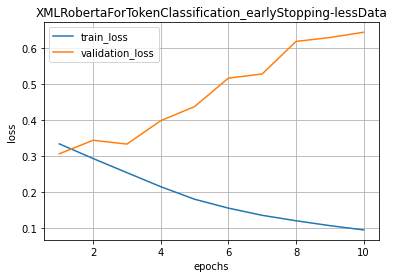

In [28]:
epochs = np.arange(1,epoch+1)
plt.plot(epochs,loss_train[:-1],label='train_loss')
plt.plot(epochs,loss_test[:-1],label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.title('XMLRobertaForTokenClassification_earlyStopping-lessData')
plt.legend()

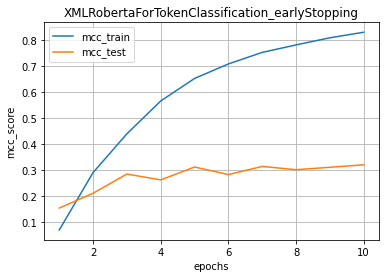

In [27]:
# epochs = np.arange(1,epoch+1)
plt.plot(epochs,mcc_score_train[:-1],label='mcc_train')
plt.plot(epochs,mcc_score_test[:-1],label='mcc_test')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.grid()
plt.show()

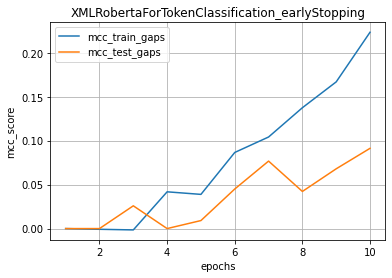

In [26]:
plt.plot(epochs,mcc_score_train_gaps[:-1],label='mcc_train_gaps')
plt.plot(epochs,mcc_score_test_gaps[:-1],label='mcc_test_gaps')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.grid()
plt.show()

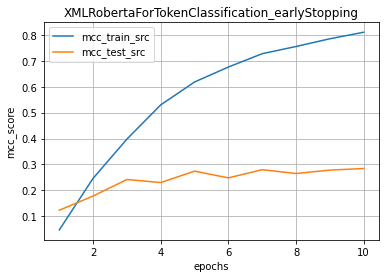

In [25]:
plt.plot(epochs,mcc_score_train_src[:-1],label='mcc_train_src')
plt.plot(epochs,mcc_score_test_src[:-1],label='mcc_test_src')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.grid()
plt.show()

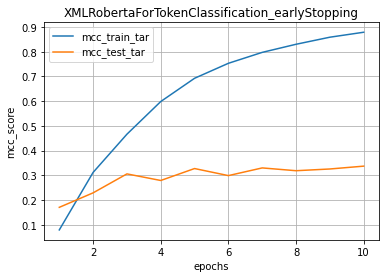

In [30]:
plt.plot(epochs,mcc_score_train_tar[:-1],label='mcc_train_tar')
plt.plot(epochs,mcc_score_test_tar[:-1],label='mcc_test_tar')
plt.xlabel('epochs')
plt.ylabel('mcc_score')
plt.title('XMLRobertaForTokenClassification_earlyStopping')
plt.legend()
plt.grid()
plt.show()

In [31]:
print('Max mcc achieved for dev data(whole sentence) is', np.amax(mcc_score_test),f',in the {np.argmax(mcc_score_test)+1}th epoch ')
print('Max mcc achieved for gaps is', np.amax(mcc_score_test_gaps),f',in the {np.argmax(mcc_score_test_gaps)+1}th epoch ')
print('Max mcc achieved for target tokens is', np.amax(mcc_score_test_tar),f',in the {np.argmax(mcc_score_test_tar)+1}th epoch ')
print('Max mcc achieved for source tokens is', np.amax(mcc_score_test_src),f',in the {np.argmax(mcc_score_test_src)+1}th epoch ')

Max mcc achieved for dev data(whole sentence) is 0.32132736100821324 ,in the 10th epoch 
Max mcc achieved for gaps is 0.09126271004355956 ,in the 10th epoch 
Max mcc achieved for target tokens is 0.3373837619138035 ,in the 10th epoch 
Max mcc achieved for source tokens is 0.2842043247673913 ,in the 10th epoch 


<h3> Running the same experiment with weighted crossentropy loss - Much better results </h3>

In [13]:
class EntityModel(nn.Module):
    
    def __init__(self):
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaModel.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
#         self.bert_drop_1 = nn.Dropout(0.3)
        self.out_tag = nn.Linear(768, 2)
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, ids, attention_mask):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                return_dict=False)
#         bo_tag = self.bert_drop_1(output_1)
        
        tag = self.out_tag(outputs[0])  
        softmax_prob = self.softmax(tag)
        
#         loss_tag = ClassificationCost(outputs[0],labels,attention_mask)
        
#         return bo_tag,loss
        return softmax_prob, tag
        

In [16]:
# model = EntityModel()
# model.cuda()

In [15]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(train_data) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
early_stopping = EarlyStopping(patience=4)

/opt/conda/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [16]:
best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta_lessData_wl.txt', 'w') as f:
    f.write('metrics_xlmroberta_lessData_wl (4800)'+'\n')
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[21],train_metrics[22]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[21],test_metrics[22]))
            print('For gaps : ',classification_report(test_metrics[27],test_metrics[28]) )
            print('For tar :',classification_report(test_metrics[25],test_metrics[26]) )
            print('For source : ',classification_report(test_metrics[23],test_metrics[24]) )
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            train_loss_lst.append(train_metrics[:-2])
            val_loss_lst.append(test_metrics[:-14])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            if early_stopping.step(float("{:.3f}".format(test_metrics[4]))): #mcc score for early stopping "{:.2f}".format(a_float)
                  break  # early stop criterion is met, we can stop now
            if float("{:.2f}".format(test_metrics[4])) >  best_accuracy:
                torch.save(model.state_dict(), '../models/training_data/model_xlmrobertatokenclassificationmodel_lessData_weightedlss.bin')
                best_accuracy = float("{:.3f}".format(test_metrics[4]))
                print('Model saved for this epoch!')

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:35<00:00,  2.18it/s]


Average F1 Training score for class 0 : 0.3798181132786731
Average F1 Training score for class 1 : 0.7906944383704334
Average Accuracy Training score  : 0.6870175229998662
Average mcc Training score  : 0.2951801678141023
Average F1 Training score for source sentence class 0 : 0.3631896481122546
Average F1 Training score for source sentence class 1 : 0.7326939163715952
Average Accuracy Training score source sentence  : 0.623448320392581
Average mcc Training score source sentence : 0.24947059537056385
Average F1 Training score for target sentence class 0 : 0.4030313395185771
Average F1 Training score for target sentence class 1 : 0.6662363894964561
Average Accuracy Training score target sentence  : 0.5718502050672697
Average mcc Training score target sentence : 0.25757809983129304
Average F1 Training score for gaps in target sentence class 0 : 0.057471264367816084
Average F1 Training score for gaps in target sentence class 1 : 0.9827032124378047
Average Accuracy Training score gaps in ta

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.25      0.75      0.38     42923
           1       0.95      0.68      0.79    293492

    accuracy                           0.69    336415
   macro avg       0.60      0.71      0.59    336415
weighted avg       0.86      0.69      0.74    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:50<00:00,  7.98it/s]


Average F1 Validation score for whole sentence class 0 : 0.4384871855319435
Average F1 Validation score for whole sentence class 1 : 0.8601926930913909
Average Accuracy Validation score whole sentence  : 0.7761262168512923
Average mcc Validation score whole sentence : 0.358071834788337
Average F1 Validation score for source sentence class 0 : 0.4225539501343764
Average F1 Validation score for source sentence class 1 : 0.8293503817814369
Average Accuracy Validation score source sentence  : 0.7365552237356447
Average mcc Validation score source sentence : 0.3202224794190575
Average F1 Validation score for target sentence class 0 : 0.4658292787198957
Average F1 Validation score for target sentence class 1 : 0.7886014453637982
Average Accuracy Validation score target sentence  : 0.697082693573152
Average mcc Validation score target sentence : 0.34235160865815745
Average F1 Validation score for gaps in target sentence class 0 : 0.12536811106436685
Average F1 Validation score for gaps in tar

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 2 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:43<00:00,  2.11it/s]


Average F1 Training score for class 0 : 0.44851218877418236
Average F1 Training score for class 1 : 0.841980270718327
Average Accuracy Training score  : 0.7543480522568851
Average mcc Training score  : 0.3819565926156311
Average F1 Training score for source sentence class 0 : 0.43135427346444216
Average F1 Training score for source sentence class 1 : 0.800427429643118
Average Accuracy Training score source sentence  : 0.704547288898933
Average mcc Training score source sentence : 0.34402294125808897
Average F1 Training score for target sentence class 0 : 0.47818851923527306
Average F1 Training score for target sentence class 1 : 0.7645066003571369
Average Accuracy Training score target sentence  : 0.675472421326996
Average mcc Training score target sentence : 0.36915165152741236
Average F1 Training score for gaps in target sentence class 0 : 0.1489655172413793
Average F1 Training score for gaps in target sentence class 1 : 0.9768326720652841
Average Accuracy Training score gaps in targ

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.31      0.78      0.45     42923
           1       0.96      0.75      0.84    293492

    accuracy                           0.75    336415
   macro avg       0.64      0.77      0.65    336415
weighted avg       0.88      0.75      0.79    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:50<00:00,  7.87it/s]


Average F1 Validation score for whole sentence class 0 : 0.45295880745868816
Average F1 Validation score for whole sentence class 1 : 0.8889535008937993
Average Accuracy Validation score whole sentence  : 0.8153832382231174
Average mcc Validation score whole sentence : 0.36676569693094435
Average F1 Validation score for source sentence class 0 : 0.4323475858604885
Average F1 Validation score for source sentence class 1 : 0.8639366713320392
Average Accuracy Validation score source sentence  : 0.780488989244179
Average mcc Validation score source sentence : 0.32601239411630417
Average F1 Validation score for target sentence class 0 : 0.4885904066276133
Average F1 Validation score for target sentence class 1 : 0.8424605301903462
Average Accuracy Validation score target sentence  : 0.7591230763902518
Average mcc Validation score target sentence : 0.3648739068795098
Average F1 Validation score for gaps in target sentence class 0 : 0.16296835212804656
Average F1 Validation score for gaps in 

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 3 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:41<00:00,  2.13it/s]


Average F1 Training score for class 0 : 0.5145472089827188
Average F1 Training score for class 1 : 0.8761123361577811
Average Accuracy Training score  : 0.8026009541786187
Average mcc Training score  : 0.46118020728955444
Average F1 Training score for source sentence class 0 : 0.4996661359083671
Average F1 Training score for source sentence class 1 : 0.8456985358178141
Average Accuracy Training score source sentence  : 0.7641366285170059
Average mcc Training score source sentence : 0.43149462799066357
Average F1 Training score for target sentence class 0 : 0.548815697650552
Average F1 Training score for target sentence class 1 : 0.8244333338657892
Average Accuracy Training score target sentence  : 0.7472268005672889
Average mcc Training score target sentence : 0.4632665097764994
Average F1 Training score for gaps in target sentence class 0 : 0.20648078372268275
Average F1 Training score for gaps in target sentence class 1 : 0.973482082147624
Average Accuracy Training score gaps in targ

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.37      0.82      0.51     42923
           1       0.97      0.80      0.88    293492

    accuracy                           0.80    336415
   macro avg       0.67      0.81      0.70    336415
weighted avg       0.89      0.80      0.83    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:50<00:00,  7.96it/s]


Average F1 Validation score for whole sentence class 0 : 0.45436930211873827
Average F1 Validation score for whole sentence class 1 : 0.9105103571875129
Average Accuracy Validation score whole sentence  : 0.8462392301667226
Average mcc Validation score whole sentence : 0.368573315806323
Average F1 Validation score for source sentence class 0 : 0.434360286212138
Average F1 Validation score for source sentence class 1 : 0.8892614770459083
Average Accuracy Validation score source sentence  : 0.8147837910020151
Average mcc Validation score source sentence : 0.3303491172443054
Average F1 Validation score for target sentence class 0 : 0.48964597837357426
Average F1 Validation score for target sentence class 1 : 0.8764974513753971
Average Accuracy Validation score target sentence  : 0.8011221297375924
Average mcc Validation score target sentence : 0.37074971857691663
Average F1 Validation score for gaps in target sentence class 0 : 0.16293643688451206
Average F1 Validation score for gaps in t

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 4 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:43<00:00,  2.12it/s]


Average F1 Training score for class 0 : 0.579657441516325
Average F1 Training score for class 1 : 0.9021557899982777
Average Accuracy Training score  : 0.8412615370896066
Average mcc Training score  : 0.5367451292415081
Average F1 Training score for source sentence class 0 : 0.5643277551246333
Average F1 Training score for source sentence class 1 : 0.8780301347644849
Average Accuracy Training score source sentence  : 0.8094158097790117
Average mcc Training score source sentence : 0.5104262687056028
Average F1 Training score for target sentence class 0 : 0.6215754962723435
Average F1 Training score for target sentence class 1 : 0.8697627929023349
Average Accuracy Training score target sentence  : 0.8062171796542604
Average mcc Training score target sentence : 0.554480810849964
Average F1 Training score for gaps in target sentence class 0 : 0.2540102530180255
Average F1 Training score for gaps in target sentence class 1 : 0.971466884254603
Average Accuracy Training score gaps in target s

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.44      0.86      0.58     42923
           1       0.98      0.84      0.90    293492

    accuracy                           0.84    336415
   macro avg       0.71      0.85      0.74    336415
weighted avg       0.91      0.84      0.86    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:50<00:00,  7.87it/s]


Average F1 Validation score for whole sentence class 0 : 0.4371233155007787
Average F1 Validation score for whole sentence class 1 : 0.9142611054664734
Average Accuracy Validation score whole sentence  : 0.8511894371713102
Average mcc Validation score whole sentence : 0.35199921991220096
Average F1 Validation score for source sentence class 0 : 0.41777813923227064
Average F1 Validation score for source sentence class 1 : 0.8978424041782014
Average Accuracy Validation score source sentence  : 0.8261830189137349
Average mcc Validation score source sentence : 0.3165181461407162
Average F1 Validation score for target sentence class 0 : 0.4771806729389252
Average F1 Validation score for target sentence class 1 : 0.88446439772495
Average Accuracy Validation score target sentence  : 0.8107502799552072
Average mcc Validation score target sentence : 0.3621138273278426
Average F1 Validation score for gaps in target sentence class 0 : 0.18711951297661003
Average F1 Validation score for gaps in ta

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 5 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:44<00:00,  2.11it/s]


Average F1 Training score for class 0 : 0.6337873884721839
Average F1 Training score for class 1 : 0.9208392002761907
Average Accuracy Training score  : 0.869818527711309
Average mcc Training score  : 0.5971665239671613
Average F1 Training score for source sentence class 0 : 0.6188926358716963
Average F1 Training score for source sentence class 1 : 0.9012256595796576
Average Accuracy Training score source sentence  : 0.8431128831780981
Average mcc Training score source sentence : 0.5740383708363322
Average F1 Training score for target sentence class 0 : 0.6818877099199767
Average F1 Training score for target sentence class 1 : 0.9006102131469995
Average Accuracy Training score target sentence  : 0.8485415309134118
Average mcc Training score target sentence : 0.6261954174812793
Average F1 Training score for gaps in target sentence class 0 : 0.2899042914479778
Average F1 Training score for gaps in target sentence class 1 : 0.9708244009488411
Average Accuracy Training score gaps in target

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.49      0.88      0.63     42923
           1       0.98      0.87      0.92    293492

    accuracy                           0.87    336415
   macro avg       0.74      0.88      0.78    336415
weighted avg       0.92      0.87      0.88    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:50<00:00,  7.93it/s]


Average F1 Validation score for whole sentence class 0 : 0.4407177953428754
Average F1 Validation score for whole sentence class 1 : 0.9195859505782256
Average Accuracy Validation score whole sentence  : 0.8593890567304464
Average mcc Validation score whole sentence : 0.36031690697926705
Average F1 Validation score for source sentence class 0 : 0.4220447149317442
Average F1 Validation score for source sentence class 1 : 0.9030739898077075
Average Accuracy Validation score source sentence  : 0.8339888799864035
Average mcc Validation score source sentence : 0.32518583383234206
Average F1 Validation score for target sentence class 0 : 0.47794386922795223
Average F1 Validation score for target sentence class 1 : 0.8904996333926888
Average Accuracy Validation score target sentence  : 0.8189699957285185
Average mcc Validation score target sentence : 0.36847339864452905
Average F1 Validation score for gaps in target sentence class 0 : 0.1673403395311237
Average F1 Validation score for gaps in

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 6 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:44<00:00,  2.11it/s]


Average F1 Training score for class 0 : 0.675990351205664
Average F1 Training score for class 1 : 0.9333204300381543
Average Accuracy Training score  : 0.8894014832870116
Average mcc Training score  : 0.6441249624215081
Average F1 Training score for source sentence class 0 : 0.6660356003704084
Average F1 Training score for source sentence class 1 : 0.9185295254541894
Average Accuracy Training score source sentence  : 0.8690132205523898
Average mcc Training score source sentence : 0.6278619122084738
Average F1 Training score for target sentence class 0 : 0.7276531834826777
Average F1 Training score for target sentence class 1 : 0.9199577445928453
Average Accuracy Training score target sentence  : 0.8762773582736019
Average mcc Training score target sentence : 0.6803426355185203
Average F1 Training score for gaps in target sentence class 0 : 0.3066341882791231
Average F1 Training score for gaps in target sentence class 1 : 0.9692107021283366
Average Accuracy Training score gaps in target

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.54      0.90      0.68     42923
           1       0.98      0.89      0.93    293492

    accuracy                           0.89    336415
   macro avg       0.76      0.90      0.80    336415
weighted avg       0.93      0.89      0.90    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:50<00:00,  7.91it/s]


Average F1 Validation score for whole sentence class 0 : 0.4403054633460337
Average F1 Validation score for whole sentence class 1 : 0.9112593564378255
Average Accuracy Validation score whole sentence  : 0.8468076535750252
Average mcc Validation score whole sentence : 0.3535095320053506
Average F1 Validation score for source sentence class 0 : 0.42576154537989286
Average F1 Validation score for source sentence class 1 : 0.8944853601580743
Average Accuracy Validation score source sentence  : 0.8217277296234249
Average mcc Validation score source sentence : 0.32295654903457194
Average F1 Validation score for target sentence class 0 : 0.4817747611865259
Average F1 Validation score for target sentence class 1 : 0.8833811820277476
Average Accuracy Validation score target sentence  : 0.8096073700372889
Average mcc Validation score target sentence : 0.366118334448656
Average F1 Validation score for gaps in target sentence class 0 : 0.18796592119275826
Average F1 Validation score for gaps in t

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 7 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:44<00:00,  2.11it/s]


Average F1 Training score for class 0 : 0.7101558572146807
Average F1 Training score for class 1 : 0.9424984771465109
Average Accuracy Training score  : 0.9040351946256855
Average mcc Training score  : 0.681936629332497
Average F1 Training score for source sentence class 0 : 0.7000106281220108
Average F1 Training score for source sentence class 1 : 0.9296989803288651
Average Accuracy Training score source sentence  : 0.8860917851781304
Average mcc Training score source sentence : 0.6662657956673488
Average F1 Training score for target sentence class 0 : 0.7641053384757683
Average F1 Training score for target sentence class 1 : 0.9336064325675749
Average Accuracy Training score target sentence  : 0.8963777837402737
Average mcc Training score target sentence : 0.7233476759283972
Average F1 Training score for gaps in target sentence class 0 : 0.3387325944870702
Average F1 Training score for gaps in target sentence class 1 : 0.9703766883505404
Average Accuracy Training score gaps in target

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.58      0.92      0.71     42923
           1       0.99      0.90      0.94    293492

    accuracy                           0.90    336415
   macro avg       0.78      0.91      0.83    336415
weighted avg       0.94      0.90      0.91    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:395: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:50<00:00,  7.94it/s]


Average F1 Validation score for whole sentence class 0 : 0.4158730158730159
Average F1 Validation score for whole sentence class 1 : 0.9215292056964436
Average Accuracy Validation score whole sentence  : 0.8616448472641826
Average mcc Validation score whole sentence : 0.3388292513279457
Average F1 Validation score for source sentence class 0 : 0.4004093983624066
Average F1 Validation score for source sentence class 1 : 0.9052967471674772
Average Accuracy Validation score source sentence  : 0.8364289703061646
Average mcc Validation score source sentence : 0.3061609271115144
Average F1 Validation score for target sentence class 0 : 0.45236724708591164
Average F1 Validation score for target sentence class 1 : 0.895342601377831
Average Accuracy Validation score target sentence  : 0.8242689417115941
Average mcc Validation score target sentence : 0.3507288752424182
Average F1 Validation score for gaps in target sentence class 0 : 0.16440422322775264
Average F1 Validation score for gaps in ta

In [17]:
train_metrices = np.array(train_loss_lst)
test_metrices = np.array(val_loss_lst)
loss_train = train_metrices[:,0]
loss_test = test_metrices[:,0]
f1_class0_train = train_metrices[:,1]
f1_class0_test= test_metrices[:,1]
f1_class1_train = train_metrices[:,2]
f1_class1_test = test_metrices[:,2]
accuracy_score_train = train_metrices[:,3]
accuracy_score_test = test_metrices[:,3]
mcc_score_train = train_metrices[:,4]
mcc_score_test = test_metrices[:,4]
f1_class0_train_src = train_metrices[:,5]
f1_class0_test_src= test_metrices[:,5]
f1_class1_train_src = train_metrices[:,6]
f1_class1_test_src = test_metrices[:,6]
accuracy_score_train_src = train_metrices[:,7]
accuracy_score_test_src = test_metrices[:,7]
mcc_score_train_src = train_metrices[:,8]
mcc_score_test_src = test_metrices[:,8]

f1_class0_train_tar = train_metrices[:,9]
f1_class0_test_tar= test_metrices[:,9]
f1_class1_train_tar = train_metrices[:,10]
f1_class1_test_tar = test_metrices[:,10]
accuracy_score_train_tar = train_metrices[:,11]
accuracy_score_test_tar = test_metrices[:,11]
mcc_score_train_tar = train_metrices[:,12]
mcc_score_test_tar = test_metrices[:,12]

f1_class0_train_gaps = train_metrices[:,13]
f1_class0_test_gaps= test_metrices[:,13]
f1_class1_train_gaps = train_metrices[:,14]
f1_class1_test_gaps = test_metrices[:,14]
accuracy_score_train_gaps = train_metrices[:,15]
accuracy_score_test_gaps = test_metrices[:,15]
mcc_score_train_gaps = train_metrices[:,16]
mcc_score_test_gaps = test_metrices[:,16]
print('loss_train :',list(loss_train),'\n','loss_test : ',list(loss_test),'\n','f1_class0_train :',list(f1_class0_train),'\n','f1_class0_test :',list(f1_class0_test),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test :', list(mcc_score_test),'\n','f1_class0_train_src :',list(f1_class0_train_src),'\n','f1_class0_test_src :',list(f1_class0_test_src),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test_src :', list(mcc_score_test_src), '\n','f1_class0_train_tar :',list(f1_class0_train_tar),'\n','f1_class0_test_tar :',list(f1_class0_test_tar),'\n','f1_class1_train_tar :',list(f1_class1_train_tar),'\n','f1_class1_test_tar :',list(f1_class1_test_tar),'\n','accuracy_score_train_tar :',list(accuracy_score_train_tar),'\n','accuracy_score_test_tar :',list(accuracy_score_test_tar),'\n','mcc_score_train_tar :',list(mcc_score_train_tar),'\n',
    'mcc_score_test_tar :', list(mcc_score_test_tar),'\n','f1_class0_train_gaps :',list(f1_class0_train_gaps),'\n','f1_class0_test_gaps :',list(f1_class0_test_gaps),'\n','f1_class1_train_gaps :',list(f1_class1_train_gaps),'\n','f1_class1_test_gaps :',list(f1_class1_test_gaps),'\n','accuracy_score_train_gaps :',list(accuracy_score_train_gaps),'\n','accuracy_score_test_gaps :',list(accuracy_score_test_gaps),'\n','mcc_score_train_gaps :',list(mcc_score_train_gaps),'\n',
    'mcc_score_test_gaps :', list(mcc_score_test_gaps))

loss_train : [0.5642413413524627, 0.4869473072886467, 0.42240994391342, 0.35724884619315467, 0.3053588365825514, 0.2637215088432034, 0.2294702361834546] 
 loss_test :  [0.5235402708500624, 0.5567306914180518, 0.7051652515679598, 0.8948219756782055, 0.9264959625340998, 1.1400202384218574, 1.5933294772356748] 
 f1_class0_train : [0.3798181132786731, 0.44851218877418236, 0.5145472089827188, 0.579657441516325, 0.6337873884721839, 0.675990351205664, 0.7101558572146807] 
 f1_class0_test : [0.4384871855319435, 0.45295880745868816, 0.45436930211873827, 0.4371233155007787, 0.4407177953428754, 0.4403054633460337, 0.4158730158730159] 
 f1_class1_train : [0.7906944383704334, 0.841980270718327, 0.8761123361577811, 0.9021557899982777, 0.9208392002761907, 0.9333204300381543, 0.9424984771465109] 
 f1_class1_test : [0.8601926930913909, 0.8889535008937993, 0.9105103571875129, 0.9142611054664734, 0.9195859505782256, 0.9112593564378255, 0.9215292056964436] 
 accuracy_score_train : [0.6870175229998662, 0.7

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [17]:
import matplotlib.pyplot as plt
def plot_against_epochs(matrix1,matrix2,label1 , label2 ,y_label , title, epochs):
    
    epochs = np.arange(1,epoch+1)
    plt.plot(epochs,matrix1,label=label1)
    if matrix2 is not None :
        plt.plot(epochs,matrix2,label=label2)
    plt.xlabel('epochs')
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

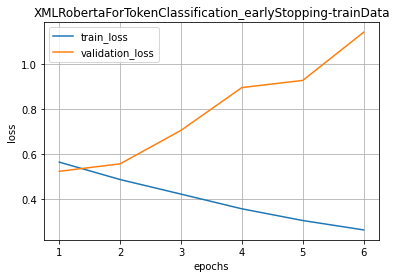

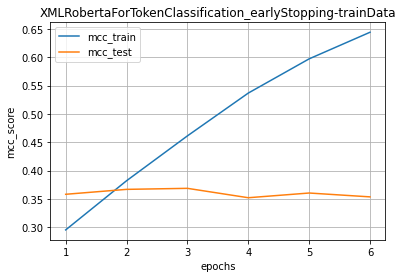

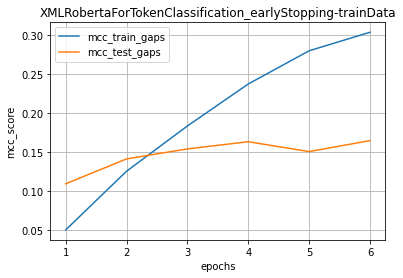

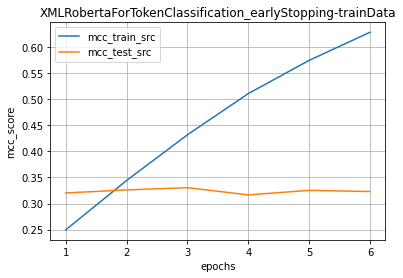

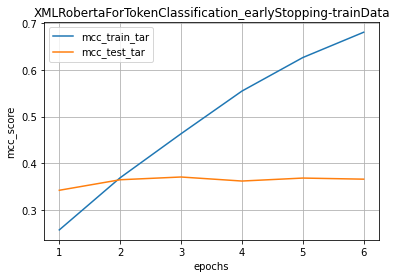

In [19]:
plot_against_epochs(loss_train[:-1],loss_test[:-1],label1 = 'train_loss', 
                    label2 = 'validation_loss', y_label = 'loss', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train[:-1],mcc_score_test[:-1],label1 = 'mcc_train', 
                    label2 = 'mcc_test', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train_gaps[:-1],mcc_score_test_gaps[:-1],label1 = 'mcc_train_gaps', 
                    label2 = 'mcc_test_gaps', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train_src[:-1],mcc_score_test_src[:-1],label1 = 'mcc_train_src', 
                    label2 = 'mcc_test_src', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )

plot_against_epochs(mcc_score_train_tar[:-1],mcc_score_test_tar[:-1],label1 = 'mcc_train_tar', 
                    label2 = 'mcc_test_tar', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )


In [21]:
print('Max mcc achieved for validation data(whole sentence) is', np.amax(mcc_score_test),f',in the {np.argmax(mcc_score_test)+1}th epoch ')
print('Max mcc achieved for gaps is', np.amax(mcc_score_test_gaps),f',in the {np.argmax(mcc_score_test_gaps)+1}th epoch ')
print('Max mcc achieved for target tokens is', np.amax(mcc_score_test_tar),f',in the {np.argmax(mcc_score_test_tar)+1}th epoch ')
print('Max mcc achieved for source tokens is', np.amax(mcc_score_test_src),f',in the {np.argmax(mcc_score_test_src)+1}th epoch ')

Max mcc achieved for validation data(whole sentence) is 0.368573315806323 ,in the 3th epoch 
Max mcc achieved for gaps is 0.16506482396326227 ,in the 6th epoch 
Max mcc achieved for target tokens is 0.37074971857691663 ,in the 3th epoch 
Max mcc achieved for source tokens is 0.3303491172443054 ,in the 3th epoch 


<h3> Using weightedLoss and dropout for less data </h3>

In [13]:
class EntityModel(nn.Module):
    
    def __init__(self,dropout=0.5):
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaModel.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
        self.bert_drop_1 = nn.Dropout(0.5)
        self.out_tag = nn.Linear(768, 2)
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, ids, attention_mask):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                return_dict=False)
        bo_tag = self.bert_drop_1(outputs[0])
        
        tag = self.out_tag(bo_tag)  
        softmax_prob = self.softmax(tag)
        
#         loss_tag = ClassificationCost(outputs[0],labels,attention_mask)
        
#         return bo_tag,loss
        return softmax_prob, tag
        

In [14]:
model = EntityModel(dropout = 0.5)
model.cuda()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyboardInterrupt: 

In [15]:
for name,param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = True

In [19]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(train_data) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
early_stopping = EarlyStopping(patience=4)

/opt/conda/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [17]:
best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta_lessData_wl_dropout.txt', 'w') as f:
    f.write('metrics_xlmroberta_lessData_wl_dropout'+'\n')
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[21],train_metrics[22]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[21],test_metrics[22]))
            print('For gaps : ',classification_report(test_metrics[27],test_metrics[28]) )
            print('For tar :',classification_report(test_metrics[25],test_metrics[26]) )
            print('For source : ',classification_report(test_metrics[23],test_metrics[24]) )
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            train_loss_lst.append(train_metrics[:-14])
            val_loss_lst.append(test_metrics[:-14])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            if early_stopping.step(float("{:.3f}".format(test_metrics[4]))): #mcc score for early stopping "{:.2f}".format(a_float)
                  break  # early stop criterion is met, we can stop now
            if float("{:.2f}".format(test_metrics[4])) >  best_accuracy:
                torch.save(model.state_dict(), '../models/training_data/model_xlmrobertatokenclassificationmodel_lessData_weightedlss_dropout.bin')
                best_accuracy = float("{:.3f}".format(test_metrics[4]))

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:14<00:00,  2.36it/s]


Average F1 Training score for class 0 : 0.3714191868240152
Average F1 Training score for class 1 : 0.7866615704963589
Average Accuracy Training score  : 0.6814410772409079
Average mcc Training score  : 0.28252661335490886
Average F1 Training score for source sentence class 0 : 0.35413709666517973
Average F1 Training score for source sentence class 1 : 0.725122109780864
Average Accuracy Training score source sentence  : 0.6143682706742644
Average mcc Training score source sentence : 0.23495945434693263
Average F1 Training score for target sentence class 0 : 0.3958290956974167
Average F1 Training score for target sentence class 1 : 0.6630364041294237
Average Accuracy Training score target sentence  : 0.5673655563647514
Average mcc Training score target sentence : 0.2438254706241568
Average F1 Training score for gaps in target sentence class 0 : 0.04893754024468771
Average F1 Training score for gaps in target sentence class 1 : 0.9816565034339721
Average Accuracy Training score gaps in ta

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.25      0.74      0.37     42923
           1       0.95      0.67      0.79    293492

    accuracy                           0.68    336415
   macro avg       0.60      0.71      0.58    336415
weighted avg       0.86      0.68      0.73    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:43<00:00,  9.17it/s]


Average F1 Validation score for whole sentence class 0 : 0.42281927537275804
Average F1 Validation score for whole sentence class 1 : 0.8395882963602721
Average Accuracy Validation score whole sentence  : 0.748949311849614
Average mcc Validation score whole sentence : 0.34478311926841154
Average F1 Validation score for source sentence class 0 : 0.40380262562245356
Average F1 Validation score for source sentence class 1 : 0.7961914690862295
Average Accuracy Validation score source sentence  : 0.6962269648189963
Average mcc Validation score source sentence : 0.3020329146264476
Average F1 Validation score for target sentence class 0 : 0.449576597382602
Average F1 Validation score for target sentence class 1 : 0.7556737204437295
Average Accuracy Validation score target sentence  : 0.6615716743053071
Average mcc Validation score target sentence : 0.32494140430300733
Average F1 Validation score for gaps in target sentence class 0 : 0.10148641722193746
Average F1 Validation score for gaps in 

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 2 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:14<00:00,  2.36it/s]


Average F1 Training score for class 0 : 0.44152340650621524
Average F1 Training score for class 1 : 0.8380643800686363
Average Accuracy Training score  : 0.7489291500081744
Average mcc Training score  : 0.37313608023955985
Average F1 Training score for source sentence class 0 : 0.4247665061316182
Average F1 Training score for source sentence class 1 : 0.7954924646481223
Average Accuracy Training score source sentence  : 0.6982598589162052
Average mcc Training score source sentence : 0.3351185977830256
Average F1 Training score for target sentence class 0 : 0.47100119860081696
Average F1 Training score for target sentence class 1 : 0.7585413782323255
Average Accuracy Training score target sentence  : 0.6684273065276554
Average mcc Training score target sentence : 0.35850007447039994
Average F1 Training score for gaps in target sentence class 0 : 0.14709159794963228
Average F1 Training score for gaps in target sentence class 1 : 0.976029864020995
Average Accuracy Training score gaps in t

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.31      0.78      0.44     42923
           1       0.96      0.74      0.84    293492

    accuracy                           0.75    336415
   macro avg       0.63      0.76      0.64    336415
weighted avg       0.88      0.75      0.79    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:44<00:00,  9.08it/s]


Average F1 Validation score for whole sentence class 0 : 0.4515018283746674
Average F1 Validation score for whole sentence class 1 : 0.8976309786519868
Average Accuracy Validation score whole sentence  : 0.8274633545932639
Average mcc Validation score whole sentence : 0.36354603992235174
Average F1 Validation score for source sentence class 0 : 0.42991409802930775
Average F1 Validation score for source sentence class 1 : 0.8747029164167833
Average Accuracy Validation score source sentence  : 0.7945589627795178
Average mcc Validation score source sentence : 0.32253937444116676
Average F1 Validation score for target sentence class 0 : 0.4867492551356437
Average F1 Validation score for target sentence class 1 : 0.8545117795228923
Average Accuracy Validation score target sentence  : 0.7732882326456633
Average mcc Validation score target sentence : 0.36209992799412327
Average F1 Validation score for gaps in target sentence class 0 : 0.1482433590402742
Average F1 Validation score for gaps in

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch 3 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:16<00:00,  2.34it/s]


Average F1 Training score for class 0 : 0.5104739699078291
Average F1 Training score for class 1 : 0.874557726598019
Average Accuracy Training score  : 0.8002913068680053
Average mcc Training score  : 0.45611840701690565
Average F1 Training score for source sentence class 0 : 0.4950825819427636
Average F1 Training score for source sentence class 1 : 0.8433697991296853
Average Accuracy Training score source sentence  : 0.7609081663949377
Average mcc Training score source sentence : 0.4255752973039379
Average F1 Training score for target sentence class 0 : 0.5446864182725067
Average F1 Training score for target sentence class 1 : 0.8218247365501942
Average Accuracy Training score target sentence  : 0.7438767296561769
Average mcc Training score target sentence : 0.45769478472893593
Average F1 Training score for gaps in target sentence class 0 : 0.2012312427856868
Average F1 Training score for gaps in target sentence class 1 : 0.9738779208032917
Average Accuracy Training score gaps in targ

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.37      0.82      0.51     42923
           1       0.97      0.80      0.87    293492

    accuracy                           0.80    336415
   macro avg       0.67      0.81      0.69    336415
weighted avg       0.89      0.80      0.83    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:45<00:00,  8.83it/s]


Average F1 Validation score for whole sentence class 0 : 0.44955537073763674
Average F1 Validation score for whole sentence class 1 : 0.9104510233499684
Average Accuracy Validation score whole sentence  : 0.8459617321248741
Average mcc Validation score whole sentence : 0.36322061737454153
Average F1 Validation score for source sentence class 0 : 0.42880119693285956
Average F1 Validation score for source sentence class 1 : 0.8893510031663684
Average Accuracy Validation score source sentence  : 0.8146138344623304
Average mcc Validation score source sentence : 0.3240449676454231
Average F1 Validation score for target sentence class 0 : 0.4867705906946186
Average F1 Validation score for target sentence class 1 : 0.8770285354474943
Average Accuracy Validation score target sentence  : 0.8015954560672355
Average mcc Validation score target sentence : 0.36774140232026814
Average F1 Validation score for gaps in target sentence class 0 : 0.14937038645245332
Average F1 Validation score for gaps i

  0%|          | 0/600 [00:00<?, ?it/s]

For tar :               precision    recall  f1-score   support

         0.0       0.44      0.54      0.49     15148
         1.0       0.90      0.86      0.88     71473

    accuracy                           0.80     86621
   macro avg       0.67      0.70      0.68     86621
weighted avg       0.82      0.80      0.81     86621

For source :                precision    recall  f1-score   support

         0.0       0.38      0.49      0.43     11663
         1.0       0.91      0.87      0.89     70711

    accuracy                           0.81     82374
   macro avg       0.65      0.68      0.66     82374
weighted avg       0.84      0.81      0.82     82374

Train Loss = 0.4297033467640479 Valid Loss = 0.745652659535408
Epoch 4 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:15<00:00,  2.35it/s]


Average F1 Training score for class 0 : 0.580080008854735
Average F1 Training score for class 1 : 0.9027828620795688
Average Accuracy Training score  : 0.8421176225792548
Average mcc Training score  : 0.5366240066175143
Average F1 Training score for source sentence class 0 : 0.5661953011914042
Average F1 Training score for source sentence class 1 : 0.8794492290237739
Average Accuracy Training score source sentence  : 0.8113286735863372
Average mcc Training score source sentence : 0.5120483691190265
Average F1 Training score for target sentence class 0 : 0.6207497296647844
Average F1 Training score for target sentence class 1 : 0.8700400399370066
Average Accuracy Training score target sentence  : 0.8064164973743724
Average mcc Training score target sentence : 0.5527645811774269
Average F1 Training score for gaps in target sentence class 0 : 0.2543218085106383
Average F1 Training score for gaps in target sentence class 1 : 0.9716305777597896
Average Accuracy Training score gaps in target

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.44      0.85      0.58     42923
           1       0.98      0.84      0.90    293492

    accuracy                           0.84    336415
   macro avg       0.71      0.85      0.74    336415
weighted avg       0.91      0.84      0.86    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:44<00:00,  9.06it/s]


Average F1 Validation score for whole sentence class 0 : 0.41538098093732395
Average F1 Validation score for whole sentence class 1 : 0.9178936299994129
Average Accuracy Validation score whole sentence  : 0.8560098467047108
Average mcc Validation score whole sentence : 0.3335050220671384
Average F1 Validation score for source sentence class 0 : 0.3970388540890971
Average F1 Validation score for source sentence class 1 : 0.9030080538898949
Average Accuracy Validation score source sentence  : 0.8328963022312865
Average mcc Validation score source sentence : 0.30019613725228034
Average F1 Validation score for target sentence class 0 : 0.45693763381448993
Average F1 Validation score for target sentence class 1 : 0.8910066258212969
Average Accuracy Validation score target sentence  : 0.8184504912203738
Average mcc Validation score target sentence : 0.34876019574141087
Average F1 Validation score for gaps in target sentence class 0 : 0.1733497840838988
Average F1 Validation score for gaps in

  0%|          | 0/600 [00:00<?, ?it/s]

For tar :               precision    recall  f1-score   support

         0.0       0.48      0.44      0.46     15148
         1.0       0.88      0.90      0.89     71473

    accuracy                           0.82     86621
   macro avg       0.68      0.67      0.67     86621
weighted avg       0.81      0.82      0.82     86621

For source :                precision    recall  f1-score   support

         0.0       0.41      0.39      0.40     11663
         1.0       0.90      0.91      0.90     70711

    accuracy                           0.83     82374
   macro avg       0.65      0.65      0.65     82374
weighted avg       0.83      0.83      0.83     82374

Train Loss = 0.3594365575661262 Valid Loss = 0.9624694767221809
Epoch 5 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:17<00:00,  2.33it/s]


Average F1 Training score for class 0 : 0.6319751623295331
Average F1 Training score for class 1 : 0.9202621281274186
Average Accuracy Training score  : 0.8689237994738641
Average mcc Training score  : 0.5951558990723224
Average F1 Training score for source sentence class 0 : 0.6179836939479461
Average F1 Training score for source sentence class 1 : 0.900941190819832
Average Accuracy Training score source sentence  : 0.8426770407916189
Average mcc Training score source sentence : 0.5728965351004954
Average F1 Training score for target sentence class 0 : 0.6786281206407234
Average F1 Training score for target sentence class 1 : 0.8990394060134091
Average Accuracy Training score target sentence  : 0.8463490359921806
Average mcc Training score target sentence : 0.6224274653899824
Average F1 Training score for gaps in target sentence class 0 : 0.2903376380893107
Average F1 Training score for gaps in target sentence class 1 : 0.9710811136402543
Average Accuracy Training score gaps in target

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.49      0.88      0.63     42923
           1       0.98      0.87      0.92    293492

    accuracy                           0.87    336415
   macro avg       0.74      0.87      0.78    336415
weighted avg       0.92      0.87      0.88    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:46<00:00,  8.65it/s]


Average F1 Validation score for whole sentence class 0 : 0.43136054421768705
Average F1 Validation score for whole sentence class 1 : 0.9138358458961473
Average Accuracy Validation score whole sentence  : 0.8503479914960278
Average mcc Validation score whole sentence : 0.3456866943818539
Average F1 Validation score for source sentence class 0 : 0.41415699326244015
Average F1 Validation score for source sentence class 1 : 0.8969809435443581
Average Accuracy Validation score source sentence  : 0.8247748075849176
Average mcc Validation score source sentence : 0.312093059321843
Average F1 Validation score for target sentence class 0 : 0.4702652065768647
Average F1 Validation score for target sentence class 1 : 0.8847454053484204
Average Accuracy Validation score target sentence  : 0.8106810126874545
Average mcc Validation score target sentence : 0.3551946165588394
Average F1 Validation score for gaps in target sentence class 0 : 0.18783151326053044
Average F1 Validation score for gaps in t

  0%|          | 0/600 [00:00<?, ?it/s]

For tar :               precision    recall  f1-score   support

         0.0       0.46      0.48      0.47     15148
         1.0       0.89      0.88      0.88     71473

    accuracy                           0.81     86621
   macro avg       0.67      0.68      0.68     86621
weighted avg       0.81      0.81      0.81     86621

For source :                precision    recall  f1-score   support

         0.0       0.39      0.44      0.41     11663
         1.0       0.91      0.89      0.90     70711

    accuracy                           0.82     82374
   macro avg       0.65      0.66      0.66     82374
weighted avg       0.83      0.82      0.83     82374

Train Loss = 0.30597673195103803 Valid Loss = 1.0196712786704303
Epoch 6 of 20


INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 600/600 [04:26<00:00,  2.25it/s]


Average F1 Training score for class 0 : 0.6735244841445525
Average F1 Training score for class 1 : 0.9325560000932513
Average Accuracy Training score  : 0.8882065306243776
Average mcc Training score  : 0.6415237731482178
Average F1 Training score for source sentence class 0 : 0.661942117444647
Average F1 Training score for source sentence class 1 : 0.9170490468556035
Average Accuracy Training score source sentence  : 0.8667855816881629
Average mcc Training score source sentence : 0.6233217456588842
Average F1 Training score for target sentence class 0 : 0.7252957142378448
Average F1 Training score for target sentence class 1 : 0.9185105663903302
Average Accuracy Training score target sentence  : 0.8743071792709571
Average mcc Training score target sentence : 0.6783264379876812
Average F1 Training score for gaps in target sentence class 0 : 0.29605263157894735
Average F1 Training score for gaps in target sentence class 1 : 0.9700995833756731
Average Accuracy Training score gaps in targe

  0%|          | 0/400 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.54      0.90      0.67     42923
           1       0.98      0.89      0.93    293492

    accuracy                           0.89    336415
   macro avg       0.76      0.89      0.80    336415
weighted avg       0.93      0.89      0.90    336415



INFO:numexpr.utils:NumExpr defaulting to 8 threads.INFO:numexpr.utils:NumExpr defaulting to 8 threads.

/root/Thesis/src/code/code_files/engine.py:399: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 400/400 [00:44<00:00,  9.03it/s]


Average F1 Validation score for whole sentence class 0 : 0.4358757730390997
Average F1 Validation score for whole sentence class 1 : 0.9138799178678663
Average Accuracy Validation score whole sentence  : 0.8505717802394539
Average mcc Validation score whole sentence : 0.3504234410866963
Average F1 Validation score for source sentence class 0 : 0.4234430461439174
Average F1 Validation score for source sentence class 1 : 0.8978679013404213
Average Accuracy Validation score source sentence  : 0.8264743729817661
Average mcc Validation score source sentence : 0.322512341546609
Average F1 Validation score for target sentence class 0 : 0.47723275356654293
Average F1 Validation score for target sentence class 1 : 0.8874000280622981
Average Accuracy Validation score target sentence  : 0.8147100587617322
Average mcc Validation score target sentence : 0.3647038163629463
Average F1 Validation score for gaps in target sentence class 0 : 0.17516268980477223
Average F1 Validation score for gaps in ta

In [18]:
train_metrices = np.array(train_loss_lst)
test_metrices = np.array(val_loss_lst)
loss_train = train_metrices[:,0]
loss_test = test_metrices[:,0]
f1_class0_train = train_metrices[:,1]
f1_class0_test= test_metrices[:,1]
f1_class1_train = train_metrices[:,2]
f1_class1_test = test_metrices[:,2]
accuracy_score_train = train_metrices[:,3]
accuracy_score_test = test_metrices[:,3]
mcc_score_train = train_metrices[:,4]
mcc_score_test = test_metrices[:,4]
f1_class0_train_src = train_metrices[:,5]
f1_class0_test_src= test_metrices[:,5]
f1_class1_train_src = train_metrices[:,6]
f1_class1_test_src = test_metrices[:,6]
accuracy_score_train_src = train_metrices[:,7]
accuracy_score_test_src = test_metrices[:,7]
mcc_score_train_src = train_metrices[:,8]
mcc_score_test_src = test_metrices[:,8]

f1_class0_train_tar = train_metrices[:,9]
f1_class0_test_tar= test_metrices[:,9]
f1_class1_train_tar = train_metrices[:,10]
f1_class1_test_tar = test_metrices[:,10]
accuracy_score_train_tar = train_metrices[:,11]
accuracy_score_test_tar = test_metrices[:,11]
mcc_score_train_tar = train_metrices[:,12]
mcc_score_test_tar = test_metrices[:,12]

f1_class0_train_gaps = train_metrices[:,13]
f1_class0_test_gaps= test_metrices[:,13]
f1_class1_train_gaps = train_metrices[:,14]
f1_class1_test_gaps = test_metrices[:,14]
accuracy_score_train_gaps = train_metrices[:,15]
accuracy_score_test_gaps = test_metrices[:,15]
mcc_score_train_gaps = train_metrices[:,16]
mcc_score_test_gaps = test_metrices[:,16]
print('loss_train :',list(loss_train),'\n','loss_test : ',list(loss_test),'\n','f1_class0_train :',list(f1_class0_train),'\n','f1_class0_test :',list(f1_class0_test),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test :', list(mcc_score_test),'\n','f1_class0_train_src :',list(f1_class0_train_src),'\n','f1_class0_test_src :',list(f1_class0_test_src),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test_src :', list(mcc_score_test_src), '\n','f1_class0_train_tar :',list(f1_class0_train_tar),'\n','f1_class0_test_tar :',list(f1_class0_test_tar),'\n','f1_class1_train_tar :',list(f1_class1_train_tar),'\n','f1_class1_test_tar :',list(f1_class1_test_tar),'\n','accuracy_score_train_tar :',list(accuracy_score_train_tar),'\n','accuracy_score_test_tar :',list(accuracy_score_test_tar),'\n','mcc_score_train_tar :',list(mcc_score_train_tar),'\n',
    'mcc_score_test_tar :', list(mcc_score_test_tar),'\n','f1_class0_train_gaps :',list(f1_class0_train_gaps),'\n','f1_class0_test_gaps :',list(f1_class0_test_gaps),'\n','f1_class1_train_gaps :',list(f1_class1_train_gaps),'\n','f1_class1_test_gaps :',list(f1_class1_test_gaps),'\n','accuracy_score_train_gaps :',list(accuracy_score_train_gaps),'\n','accuracy_score_test_gaps :',list(accuracy_score_test_gaps),'\n','mcc_score_train_gaps :',list(mcc_score_train_gaps),'\n',
    'mcc_score_test_gaps :', list(mcc_score_test_gaps))

loss_train : [0.574498822192351, 0.4943164877096812, 0.4297033467640479, 0.3594365575661262, 0.30597673195103803, 0.262488623422881] 
 loss_test :  [0.5243627754598856, 0.5716354344040155, 0.745652659535408, 0.9624694767221809, 1.0196712786704303, 1.2017608746141195] 
 f1_class0_train : [0.3714191868240152, 0.44152340650621524, 0.5104739699078291, 0.580080008854735, 0.6319751623295331, 0.6735244841445525] 
 f1_class0_test : [0.42281927537275804, 0.4515018283746674, 0.44955537073763674, 0.41538098093732395, 0.43136054421768705, 0.4358757730390997] 
 f1_class1_train : [0.7866615704963589, 0.8380643800686363, 0.874557726598019, 0.9027828620795688, 0.9202621281274186, 0.9325560000932513] 
 f1_class1_test : [0.8395882963602721, 0.8976309786519868, 0.9104510233499684, 0.9178936299994129, 0.9138358458961473, 0.9138799178678663] 
 accuracy_score_train : [0.6814410772409079, 0.7489291500081744, 0.8002913068680053, 0.8421176225792548, 0.8689237994738641, 0.8882065306243776] 
 accuracy_score_test

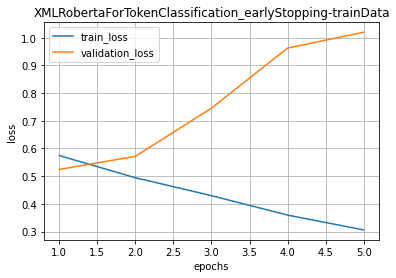

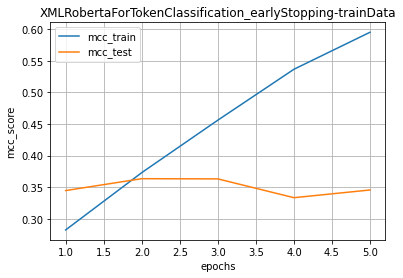

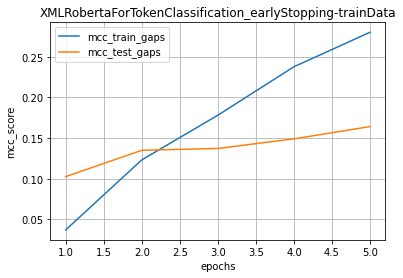

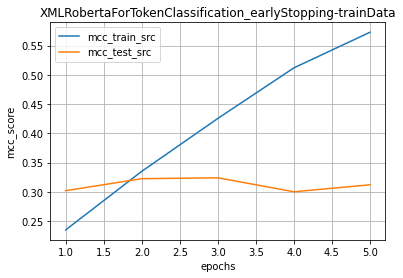

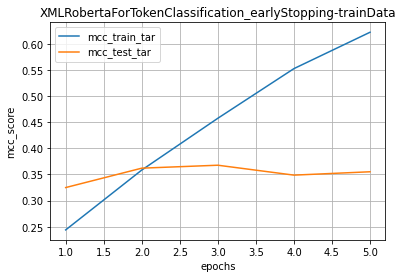

In [21]:
plot_against_epochs(loss_train[:-1],loss_test[:-1],label1 = 'train_loss', 
                    label2 = 'validation_loss', y_label = 'loss', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train[:-1],mcc_score_test[:-1],label1 = 'mcc_train', 
                    label2 = 'mcc_test', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train_gaps[:-1],mcc_score_test_gaps[:-1],label1 = 'mcc_train_gaps', 
                    label2 = 'mcc_test_gaps', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train_src[:-1],mcc_score_test_src[:-1],label1 = 'mcc_train_src', 
                    label2 = 'mcc_test_src', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )

plot_against_epochs(mcc_score_train_tar[:-1],mcc_score_test_tar[:-1],label1 = 'mcc_train_tar', 
                    label2 = 'mcc_test_tar', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )


In [22]:
print('Max mcc achieved for dev data(whole sentence) is', np.amax(mcc_score_test),f',in the {np.argmax(mcc_score_test)+1}th epoch ')
print('Max mcc achieved for gaps is', np.amax(mcc_score_test_gaps),f',in the {np.argmax(mcc_score_test_gaps)+1}th epoch ')
print('Max mcc achieved for target tokens is', np.amax(mcc_score_test_tar),f',in the {np.argmax(mcc_score_test_tar)+1}th epoch ')
print('Max mcc achieved for source tokens is', np.amax(mcc_score_test_src),f',in the {np.argmax(mcc_score_test_src)+1}th epoch ')

Max mcc achieved for dev data(whole sentence) is 0.36354603992235174 ,in the 2th epoch 
Max mcc achieved for gaps is 0.16417538964793119 ,in the 5th epoch 
Max mcc achieved for target tokens is 0.36774140232026814 ,in the 3th epoch 
Max mcc achieved for source tokens is 0.3240449676454231 ,in the 3th epoch 


In [31]:
class EntityModel(nn.Module):
    
    def __init__(self,dropout=0.3): # dropout can be passed here
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaModel.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
        self.dropout = dropout
        self.bert_drop_1 = nn.Dropout(self.dropout)
        self.out_tag = nn.Linear(768, 2)
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, ids, attention_mask):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                return_dict=False)
        bo_tag = self.bert_drop_1(outputs[0])
        
        tag = self.out_tag(bo_tag)  
        softmax_prob = self.softmax(tag)
        
#         loss_tag = ClassificationCost(outputs[0],labels,attention_mask)
        
#         return bo_tag,loss
        return softmax_prob, tag
        

In [33]:
# set_seed()
# model = EntityModel()
# model.cuda()

In [75]:
# engine = reload(engine)
# config = reload(config)


In [34]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(train_data) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=2e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)
early_stopping = EarlyStopping(patience=8)

/opt/conda/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [36]:
writer = SummaryWriter("runs/SupervisedTraining/with_500_labelled_withdropout_test")
best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta_verylessData_wl_500_test.txt', 'w') as f:
    f.write('metrics_xlmroberta_lessData_wl_(500)_test'+'\n')
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[21],train_metrics[22]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[21],test_metrics[22]))
            print('For gaps : ',classification_report(test_metrics[27],test_metrics[28]) )
            print('For tar :',classification_report(test_metrics[25],test_metrics[26]) )
            print('For source : ',classification_report(test_metrics[23],test_metrics[24]) )
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            writer.add_scalar('Train_loss',train_metrics[0], epoch)
            writer.add_scalar('Validation_loss',test_metrics[0],epoch)
            writer.add_scalar('mcc_score/Test',test_metrics[4],epoch)
            writer.add_scalar('mcc_score/Train',train_metrics[4],epoch)
            train_loss_lst.append(train_metrics[:-14])
            val_loss_lst.append(test_metrics[:-14])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            writer.add_hparams(
                    { "lr": float(config.lr),  
                     "train_data": float(len(train_dataloader)*config.TRAIN_BATCH_SIZE), 
                     "validation_data":float(len(val_dataloader)*config.TRAIN_BATCH_SIZE) 
                    },
                    {
                    "train_loss": float(train_metrics[0]),
                    "test_loss" : float(test_metrics[0]),
                    "mcc_score_test" : float(test_metrics[4])
                    },
                )
            if early_stopping.step(float("{:.3f}".format(test_metrics[4]))): #mcc score for early stopping "{:.2f}".format(a_float)
                  break  # early stop criterion is met, we can stop now
            if float("{:.3f}".format(test_metrics[4])) >  best_accuracy:
                torch.save(model.state_dict(), '../models/training_data/labeled_500_data_test.bin')
                best_accuracy = float("{:.3f}".format(test_metrics[4]))
                print('Model saved for this epoch!')
    writer.flush()
    writer.close()

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 of 25


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.29762393396269443
Average F1 Training score for class 1 : 0.6822242855669038
Average Accuracy Training score  : 0.5624218661211501
Average mcc Training score  : 0.19584933476529973
Average F1 Training score for source sentence class 0 : 0.285024154589372
Average F1 Training score for source sentence class 1 : 0.5818181818181818
Average Accuracy Training score source sentence  : 0.4722889698472987
Average mcc Training score source sentence : 0.14258893820837198
Average F1 Training score for target sentence class 0 : 0.3270407723472114
Average F1 Training score for target sentence class 1 : 0.5049774903303532
Average Accuracy Training score target sentence  : 0.42956305713868187
Average mcc Training score target sentence : 0.13444968692213694
Average F1 Training score for gaps in target sentence class 0 : 0.022388059701492536
Average F1 Training score for gaps in target sentence class 1 : 0.9521140489825758
Average Accuracy Training score gaps in

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 16/16 [00:01<00:00,  9.08it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

Average F1 Validation score for whole sentence class 0 : 0.39513803049031726
Average F1 Validation score for whole sentence class 1 : 0.7571948395633478
Average Accuracy Validation score whole sentence  : 0.6534875486840552
Average mcc Validation score whole sentence : 0.28521419725189984
Average F1 Validation score for source sentence class 0 : 0.3856115107913669
Average F1 Validation score for source sentence class 1 : 0.6940530212562693
Average Accuracy Validation score source sentence  : 0.5915178571428571
Average mcc Validation score source sentence : 0.24587693022226334
Average F1 Validation score for target sentence class 0 : 0.4158268010451661
Average F1 Validation score for target sentence class 1 : 0.5988208151755959
Average Accuracy Validation score target sentence  : 0.5243161094224924
Average mcc Validation score target sentence : 0.24431616863603886
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentenc

  0%|          | 0/63 [00:00<?, ?it/s]

Model saved for this epoch!
Epoch 2 of 25


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.369642154935116
Average F1 Training score for class 1 : 0.7866364967389857
Average Accuracy Training score  : 0.6811853619729514
Average mcc Training score  : 0.29553136448568834
Average F1 Training score for source sentence class 0 : 0.35548130060403543
Average F1 Training score for source sentence class 1 : 0.7217135564064148
Average Accuracy Training score source sentence  : 0.6112704441516161
Average mcc Training score source sentence : 0.25840763446184095
Average F1 Training score for target sentence class 0 : 0.38894554354476857
Average F1 Training score for target sentence class 1 : 0.6588864852556073
Average Accuracy Training score target sentence  : 0.5621803302645039
Average mcc Training score target sentence : 0.2492036645095201
Average F1 Training score for gaps in target sentence class 0 : 0.0
Average F1 Training score for gaps in target sentence class 1 : 0.987414725946836
Average Accuracy Training score gaps in target sentence  :

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 16/16 [00:01<00:00,  9.01it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

Average F1 Validation score for whole sentence class 0 : 0.3937641438270053
Average F1 Validation score for whole sentence class 1 : 0.8140951499730126
Average Accuracy Validation score whole sentence  : 0.7154490735276762
Average mcc Validation score whole sentence : 0.26951372554264297
Average F1 Validation score for source sentence class 0 : 0.38359201773835916
Average F1 Validation score for source sentence class 1 : 0.7511190689346463
Average Accuracy Validation score source sentence  : 0.6454081632653061
Average mcc Validation score source sentence : 0.23321828898302485
Average F1 Validation score for target sentence class 0 : 0.41958713394143066
Average F1 Validation score for target sentence class 1 : 0.7311541027351569
Average Accuracy Validation score target sentence  : 0.6325227963525836
Average mcc Validation score target sentence : 0.23643669959938268
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target senten

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.41820418204182047
Average F1 Training score for class 1 : 0.8252420010345082
Average Accuracy Training score  : 0.7312194567564496
Average mcc Training score  : 0.35782143282657064
Average F1 Training score for source sentence class 0 : 0.4064064064064063
Average F1 Training score for source sentence class 1 : 0.7793077781912914
Average Accuracy Training score source sentence  : 0.6782419967444384
Average mcc Training score source sentence : 0.3290871839515854
Average F1 Training score for target sentence class 0 : 0.43696180172223453
Average F1 Training score for target sentence class 1 : 0.7215245167631321
Average Accuracy Training score target sentence  : 0.6273564226216571
Average mcc Training score target sentence : 0.3255911436360306
Average F1 Training score for gaps in target sentence class 0 : 0.0
Average F1 Training score for gaps in target sentence class 1 : 0.9877123875595274
Average Accuracy Training score gaps in target sentence  

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 16/16 [00:01<00:00,  8.97it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

Average F1 Validation score for whole sentence class 0 : 0.4027612473220661
Average F1 Validation score for whole sentence class 1 : 0.803138485680659
Average Accuracy Validation score whole sentence  : 0.7038829222235335
Average mcc Validation score whole sentence : 0.2849550464328506
Average F1 Validation score for source sentence class 0 : 0.3837953091684435
Average F1 Validation score for source sentence class 1 : 0.7370336669699727
Average Accuracy Validation score source sentence  : 0.6313775510204082
Average mcc Validation score source sentence : 0.23515294956114446
Average F1 Validation score for target sentence class 0 : 0.4348993288590604
Average F1 Validation score for target sentence class 1 : 0.7093210586881473
Average Accuracy Validation score target sentence  : 0.6161094224924012
Average mcc Validation score target sentence : 0.2635023186456306
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence cl

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.4644936751221472
Average F1 Training score for class 1 : 0.8557104470613696
Average Accuracy Training score  : 0.772673031026253
Average mcc Training score  : 0.41244481792078264
Average F1 Training score for source sentence class 0 : 0.4547715262667081
Average F1 Training score for source sentence class 1 : 0.8188764973151591
Average Accuracy Training score source sentence  : 0.7280830943337726
Average mcc Training score source sentence : 0.3914368986155591
Average F1 Training score for target sentence class 0 : 0.486374695863747
Average F1 Training score for target sentence class 1 : 0.7795530492898914
Average Accuracy Training score target sentence  : 0.6915095718252229
Average mcc Training score target sentence : 0.3924542303165547
Average F1 Training score for gaps in target sentence class 0 : 0.05574912891986062
Average F1 Training score for gaps in target sentence class 1 : 0.9839938574212983
Average Accuracy Training score gaps in targe

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 16/16 [00:01<00:00,  8.84it/s]
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this

Average F1 Validation score for whole sentence class 0 : 0.367361873399195
Average F1 Validation score for whole sentence class 1 : 0.8783508056005066
Average Accuracy Validation score whole sentence  : 0.7959400448483418
Average mcc Validation score whole sentence : 0.24769859780930956
Average F1 Validation score for source sentence class 0 : 0.35866780529462
Average F1 Validation score for source sentence class 1 : 0.8527739658890413
Average Accuracy Validation score source sentence  : 0.7605229591836735
Average mcc Validation score source sentence : 0.21600829183779793
Average F1 Validation score for target sentence class 0 : 0.39673913043478265
Average F1 Validation score for target sentence class 1 : 0.8261550509005482
Average Accuracy Validation score target sentence  : 0.7300911854103344
Average mcc Validation score target sentence : 0.22839169272136212
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target sentence c

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.5501230012300122
Average F1 Training score for class 1 : 0.8980203541056742
Average Accuracy Training score  : 0.8337311058074781
Average mcc Training score  : 0.507708320123659
Average F1 Training score for source sentence class 0 : 0.5526509572901326
Average F1 Training score for source sentence class 1 : 0.8807069219440352
Average Accuracy Training score source sentence  : 0.8116425083326874
Average mcc Training score source sentence : 0.503595439790557
Average F1 Training score for target sentence class 0 : 0.5677083333333334
Average F1 Training score for target sentence class 1 : 0.8428969914325563
Average Accuracy Training score target sentence  : 0.7695455209703347
Average mcc Training score target sentence : 0.4966467774708555
Average F1 Training score for gaps in target sentence class 0 : 0.04285714285714286
Average F1 Training score for gaps in target sentence class 1 : 0.9841775888534656
Average Accuracy Training score gaps in target

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/63 [00:00<?, ?it/s]

Average F1 Validation score for whole sentence class 0 : 0.37343750000000003
Average F1 Validation score for whole sentence class 1 : 0.8885027109689976
Average Accuracy Validation score whole sentence  : 0.8106927888587278
Average mcc Validation score whole sentence : 0.26202449192495475
Average F1 Validation score for source sentence class 0 : 0.3626062322946175
Average F1 Validation score for source sentence class 1 : 0.8705160176481873
Average Accuracy Validation score source sentence  : 0.7847576530612245
Average mcc Validation score source sentence : 0.23327536761214465
Average F1 Validation score for target sentence class 0 : 0.40567375886524826
Average F1 Validation score for target sentence class 1 : 0.8379110251450677
Average Accuracy Validation score target sentence  : 0.7452887537993921
Average mcc Validation score target sentence : 0.24596094095002508
Average F1 Validation score for gaps in target sentence class 0 : 0.0
Average F1 Validation score for gaps in target senten

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.5960739594363443
Average F1 Training score for class 1 : 0.914669190398348
Average Accuracy Training score  : 0.8591033071939993
Average mcc Training score  : 0.5583750692078857
Average F1 Training score for source sentence class 0 : 0.5892005342491892
Average F1 Training score for source sentence class 1 : 0.8952871942026166
Average Accuracy Training score source sentence  : 0.8331137121153399
Average mcc Training score source sentence : 0.54695864571683
Average F1 Training score for target sentence class 0 : 0.6314522197140707
Average F1 Training score for target sentence class 1 : 0.8818449365561828
Average Accuracy Training score target sentence  : 0.821058015490282
Average mcc Training score target sentence : 0.5714377452044399
Average F1 Training score for gaps in target sentence class 0 : 0.08695652173913043
Average F1 Training score for gaps in target sentence class 1 : 0.9787840969869852
Average Accuracy Training score gaps in target s

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/63 [00:00<?, ?it/s]

Average F1 Validation score for whole sentence class 0 : 0.3424317617866005
Average F1 Validation score for whole sentence class 1 : 0.8905561674008812
Average Accuracy Validation score whole sentence  : 0.812345096187891
Average mcc Validation score whole sentence : 0.2334778740155743
Average F1 Validation score for source sentence class 0 : 0.33553251649387367
Average F1 Validation score for source sentence class 1 : 0.8647092688543465
Average Accuracy Validation score source sentence  : 0.7751913265306123
Average mcc Validation score source sentence : 0.20041277636853738
Average F1 Validation score for target sentence class 0 : 0.37212984956452894
Average F1 Validation score for target sentence class 1 : 0.8508557457212713
Average Accuracy Validation score target sentence  : 0.7589665653495441
Average mcc Validation score target sentence : 0.223324591262283
Average F1 Validation score for gaps in target sentence class 0 : 0.02127659574468085
Average F1 Validation score for gaps in t

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.641741357234315
Average F1 Training score for class 1 : 0.9284728258090904
Average Accuracy Training score  : 0.8807534947153085
Average mcc Training score  : 0.6089696406341434
Average F1 Training score for source sentence class 0 : 0.6442577030812325
Average F1 Training score for source sentence class 1 : 0.914535666218035
Average Accuracy Training score source sentence  : 0.8621812262615302
Average mcc Training score source sentence : 0.6113891812561809
Average F1 Training score for target sentence class 0 : 0.6785828279604214
Average F1 Training score for target sentence class 1 : 0.9045768975646735
Average Accuracy Training score target sentence  : 0.8528423206196113
Average mcc Training score target sentence : 0.6261848408109261
Average F1 Training score for gaps in target sentence class 0 : 0.10199556541019954
Average F1 Training score for gaps in target sentence class 1 : 0.9758454106280192
Average Accuracy Training score gaps in target

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/63 [00:00<?, ?it/s]

Average F1 Validation score for whole sentence class 0 : 0.3606023606023606
Average F1 Validation score for whole sentence class 1 : 0.891572917385603
Average Accuracy Validation score whole sentence  : 0.8145875132774696
Average mcc Validation score whole sentence : 0.25235982475857965
Average F1 Validation score for source sentence class 0 : 0.34947768281101615
Average F1 Validation score for source sentence class 1 : 0.868748802452577
Average Accuracy Validation score source sentence  : 0.7815688775510204
Average mcc Validation score source sentence : 0.2183086825655867
Average F1 Validation score for target sentence class 0 : 0.39389312977099233
Average F1 Validation score for target sentence class 1 : 0.8493358633776091
Average Accuracy Validation score target sentence  : 0.7586626139817629
Average mcc Validation score target sentence : 0.24324307957947178
Average F1 Validation score for gaps in target sentence class 0 : 0.02127659574468085
Average F1 Validation score for gaps in 

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.6798320078634617
Average F1 Training score for class 1 : 0.9394773736930119
Average Accuracy Training score  : 0.8981986589385157
Average mcc Training score  : 0.6494434727154819
Average F1 Training score for source sentence class 0 : 0.6832166348398049
Average F1 Training score for source sentence class 1 : 0.9292047987102281
Average Accuracy Training score source sentence  : 0.8842725370126346
Average mcc Training score source sentence : 0.651482843396702
Average F1 Training score for target sentence class 0 : 0.7187759853650424
Average F1 Training score for target sentence class 1 : 0.9208296268551898
Average Accuracy Training score target sentence  : 0.8764430805202397
Average mcc Training score target sentence : 0.6732267842104752
Average F1 Training score for gaps in target sentence class 0 : 0.14193548387096774
Average F1 Training score for gaps in target sentence class 1 : 0.976183370142661
Average Accuracy Training score gaps in target

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/63 [00:00<?, ?it/s]

Average F1 Validation score for whole sentence class 0 : 0.37325676784249384
Average F1 Validation score for whole sentence class 1 : 0.8946787979046044
Average Accuracy Validation score whole sentence  : 0.8196624572170423
Average mcc Validation score whole sentence : 0.2682650491190275
Average F1 Validation score for source sentence class 0 : 0.35114503816793896
Average F1 Validation score for source sentence class 1 : 0.8698315467075038
Average Accuracy Validation score source sentence  : 0.7831632653061225
Average mcc Validation score source sentence : 0.22101795995802545
Average F1 Validation score for target sentence class 0 : 0.42022116903633494
Average F1 Validation score for target sentence class 1 : 0.8618742943168988
Average Accuracy Validation score target sentence  : 0.7768996960486322
Average mcc Validation score target sentence : 0.28240878475943043
Average F1 Validation score for gaps in target sentence class 0 : 0.08064516129032258
Average F1 Validation score for gaps 

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
  0%|          | 0/16 [00:00<?, ?it/s]

Average F1 Training score for class 0 : 0.7076023391812865
Average F1 Training score for class 1 : 0.946171443951016
Average Accuracy Training score  : 0.9090805773383339
Average mcc Training score  : 0.6802075026735658
Average F1 Training score for source sentence class 0 : 0.7050701186623516
Average F1 Training score for source sentence class 1 : 0.9354183398686635
Average Accuracy Training score source sentence  : 0.8940392217657546
Average mcc Training score source sentence : 0.6763992000755735
Average F1 Training score for target sentence class 0 : 0.7511141583818992
Average F1 Training score for target sentence class 1 : 0.9325842696629214
Average Accuracy Training score target sentence  : 0.8939061814993424
Average mcc Training score target sentence : 0.710979390615827
Average F1 Training score for gaps in target sentence class 0 : 0.1978947368421053
Average F1 Training score for gaps in target sentence class 1 : 0.9772442214656872
Average Accuracy Training score gaps in target 

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
100%|██████████| 16/16 [00:01<00:00,  9.01it/s]


Average F1 Validation score for whole sentence class 0 : 0.3541850220264317
Average F1 Validation score for whole sentence class 1 : 0.9001090215317525
Average Accuracy Validation score whole sentence  : 0.8269798182461938
Average mcc Validation score whole sentence : 0.25771944559945303
Average F1 Validation score for source sentence class 0 : 0.3439099283520982
Average F1 Validation score for source sentence class 1 : 0.8789423984891408
Average Accuracy Validation score source sentence  : 0.7955994897959183
Average mcc Validation score source sentence : 0.2239478155699811
Average F1 Validation score for target sentence class 0 : 0.39082412914188613
Average F1 Validation score for target sentence class 1 : 0.8672959466962799
Average Accuracy Validation score target sentence  : 0.7820668693009118
Average mcc Validation score target sentence : 0.2621293175569892
Average F1 Validation score for gaps in target sentence class 0 : 0.06896551724137931
Average F1 Validation score for gaps in 

In [78]:
# very less data - 1600 data points and evaluating on 450
best_accuracy = -1
train_loss_lst = []
val_loss_lst = []
with open('metrics_xlmroberta_verylessData_wl_3000.txt', 'w') as f:
    f.write('metrics_xlmroberta_lessData_wl_(3000)'+'\n')
    for epoch in range(config.EPOCHS):
            print(f'Epoch {epoch+1} of {config.EPOCHS}')
            train_metrics = engine.train_fn(train_dataloader, model, optimizer, scheduler)
            print(classification_report(train_metrics[21],train_metrics[22]))
            test_metrics = engine.eval_fn(val_dataloader, model)
            print(classification_report(test_metrics[21],test_metrics[22]))
            print('For gaps : ',classification_report(test_metrics[27],test_metrics[28]) )
            print('For tar :',classification_report(test_metrics[25],test_metrics[26]) )
            print('For source : ',classification_report(test_metrics[23],test_metrics[24]) )
            print(f"Train Loss = {train_metrics[0]} Valid Loss = {test_metrics[0]}")
            writer.add_scalar('Train_loss',train_metrics[0], epoch)
            writer.add_scalar('Validation_loss',test_metrics[0],epoch)
            writer.add_scalar('mcc_score/Test',test_metrics[4],epoch)
            writer.add_scalar('mcc_score/Train',train_metrics[4],epoch)
            train_loss_lst.append(train_metrics[:-14])
            val_loss_lst.append(test_metrics[:-14])
            f.write(f"Train_loss {epoch+1} : {str(train_loss_lst)}" + '\n')
            f.write(f"val_loss {epoch+1} : {str(val_loss_lst)}" + '\n')
            writer.add_hparams(
                    { "lr": float(config.lr),  
                     "train_data": float(len(train_dataloader)*config.TRAIN_BATCH_SIZE), 
                     "validation_data":float(len(val_dataloader)*config.TRAIN_BATCH_SIZE) 
                    },
                    {
                    "train_loss": float(train_metrics[0]),
                    "test_loss" : float(test_metrics[0]),
                    "mcc_score_test" : float(test_metrics[4])
                    },
                )
            if early_stopping.step(float("{:.3f}".format(test_metrics[4]))): #mcc score for early stopping "{:.2f}".format(a_float)
                  break  # early stop criterion is met, we can stop now
            if float("{:.2f}".format(test_metrics[4])) >  best_accuracy:
                torch.save(model.state_dict(), '../models/training_data/model_xlmrobertatokenclassificationmodel_lessData_3000_withdropout_weightedlss.bin')
                best_accuracy = float("{:.3f}".format(test_metrics[4]))
                print('Model saved for this epoch!')

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1 of 25


INFO:numexpr.utils:NumExpr defaulting to 4 threads.
/root/Thesis/src/code/code_files/engine.py:409: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np_arr_labels = np.array(tar_labels)
 11%|█         | 7/63 [00:03<00:25,  2.21it/s]


KeyboardInterrupt: 

In [20]:
train_metrices = np.array(train_loss_lst)
test_metrices = np.array(val_loss_lst)
loss_train = train_metrices[:,0]
loss_test = test_metrices[:,0]
f1_class0_train = train_metrices[:,1]
f1_class0_test= test_metrices[:,1]
f1_class1_train = train_metrices[:,2]
f1_class1_test = test_metrices[:,2]
accuracy_score_train = train_metrices[:,3]
accuracy_score_test = test_metrices[:,3]
mcc_score_train = train_metrices[:,4]
mcc_score_test = test_metrices[:,4]
f1_class0_train_src = train_metrices[:,5]
f1_class0_test_src= test_metrices[:,5]
f1_class1_train_src = train_metrices[:,6]
f1_class1_test_src = test_metrices[:,6]
accuracy_score_train_src = train_metrices[:,7]
accuracy_score_test_src = test_metrices[:,7]
mcc_score_train_src = train_metrices[:,8]
mcc_score_test_src = test_metrices[:,8]

f1_class0_train_tar = train_metrices[:,9]
f1_class0_test_tar= test_metrices[:,9]
f1_class1_train_tar = train_metrices[:,10]
f1_class1_test_tar = test_metrices[:,10]
accuracy_score_train_tar = train_metrices[:,11]
accuracy_score_test_tar = test_metrices[:,11]
mcc_score_train_tar = train_metrices[:,12]
mcc_score_test_tar = test_metrices[:,12]

f1_class0_train_gaps = train_metrices[:,13]
f1_class0_test_gaps= test_metrices[:,13]
f1_class1_train_gaps = train_metrices[:,14]
f1_class1_test_gaps = test_metrices[:,14]
accuracy_score_train_gaps = train_metrices[:,15]
accuracy_score_test_gaps = test_metrices[:,15]
mcc_score_train_gaps = train_metrices[:,16]
mcc_score_test_gaps = test_metrices[:,16]
print('loss_train :',list(loss_train),'\n','loss_test : ',list(loss_test),'\n','f1_class0_train :',list(f1_class0_train),'\n','f1_class0_test :',list(f1_class0_test),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test :', list(mcc_score_test),'\n','f1_class0_train_src :',list(f1_class0_train_src),'\n','f1_class0_test_src :',list(f1_class0_test_src),'\n','f1_class1_train :',list(f1_class1_train),'\n','f1_class1_test :',list(f1_class1_test),'\n','accuracy_score_train :',list(accuracy_score_train),'\n','accuracy_score_test :',list(accuracy_score_test),'\n','mcc_score_train :',list(mcc_score_train),'\n',
    'mcc_score_test_src :', list(mcc_score_test_src), '\n','f1_class0_train_tar :',list(f1_class0_train_tar),'\n','f1_class0_test_tar :',list(f1_class0_test_tar),'\n','f1_class1_train_tar :',list(f1_class1_train_tar),'\n','f1_class1_test_tar :',list(f1_class1_test_tar),'\n','accuracy_score_train_tar :',list(accuracy_score_train_tar),'\n','accuracy_score_test_tar :',list(accuracy_score_test_tar),'\n','mcc_score_train_tar :',list(mcc_score_train_tar),'\n',
    'mcc_score_test_tar :', list(mcc_score_test_tar),'\n','f1_class0_train_gaps :',list(f1_class0_train_gaps),'\n','f1_class0_test_gaps :',list(f1_class0_test_gaps),'\n','f1_class1_train_gaps :',list(f1_class1_train_gaps),'\n','f1_class1_test_gaps :',list(f1_class1_test_gaps),'\n','accuracy_score_train_gaps :',list(accuracy_score_train_gaps),'\n','accuracy_score_test_gaps :',list(accuracy_score_test_gaps),'\n','mcc_score_train_gaps :',list(mcc_score_train_gaps),'\n',
    'mcc_score_test_gaps :', list(mcc_score_test_gaps))

loss_train : [0.604705545604229, 0.5409479761123657, 0.4910567319393158, 0.4342121422290802, 0.385106186568737, 0.3423638926446438, 0.3124045425653458, 0.284314361512661] 
 loss_test :  [0.5868043601512909, 0.5926832876035145, 0.6516282223165035, 0.6773789658078125, 0.7756455279886723, 0.7828835344740322, 0.9555331261030265, 1.0998158295239722] 
 f1_class0_train : [0.3250082699305325, 0.38880676894846833, 0.43266289739549546, 0.4869636289333878, 0.5349119611414693, 0.5843716707582565, 0.6101146581664209, 0.6395039858281665] 
 f1_class0_test : [0.33874788494077834, 0.3741306259493165, 0.3812581519012742, 0.39220022112775155, 0.3881636205395997, 0.3834935724316733, 0.3785878648419523, 0.3552486187845304] 
 f1_class1_train : [0.6812673287947619, 0.7850317614929994, 0.8223253005753166, 0.8583533606381657, 0.8808987017025577, 0.9019451426073654, 0.911001303214596, 0.9210364637787383] 
 f1_class1_test : [0.7342581259349924, 0.8413222805488559, 0.8811318208978238, 0.883485230929305, 0.8931935

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


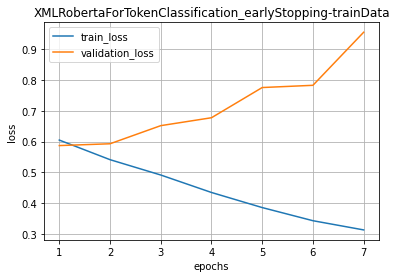

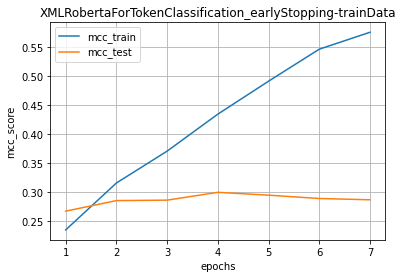

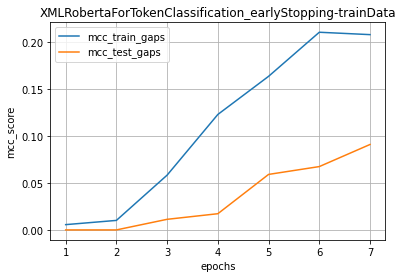

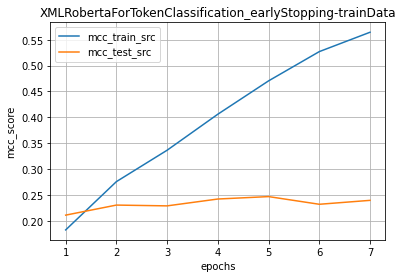

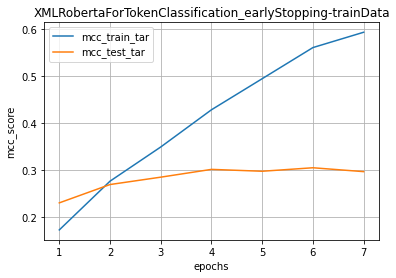

In [21]:
plot_against_epochs(loss_train[:-1],loss_test[:-1],label1 = 'train_loss', 
                    label2 = 'validation_loss', y_label = 'loss', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train[:-1],mcc_score_test[:-1],label1 = 'mcc_train', 
                    label2 = 'mcc_test', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train_gaps[:-1],mcc_score_test_gaps[:-1],label1 = 'mcc_train_gaps', 
                    label2 = 'mcc_test_gaps', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )
plot_against_epochs(mcc_score_train_src[:-1],mcc_score_test_src[:-1],label1 = 'mcc_train_src', 
                    label2 = 'mcc_test_src', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )

plot_against_epochs(mcc_score_train_tar[:-1],mcc_score_test_tar[:-1],label1 = 'mcc_train_tar', 
                    label2 = 'mcc_test_tar', y_label = 'mcc_score', title ='XMLRobertaForTokenClassification_earlyStopping-trainData', epochs = epoch )


In [22]:
print('Max mcc achieved for dev data(whole sentence) is', np.amax(mcc_score_test),f',in the {np.argmax(mcc_score_test)+1}th epoch ')
print('Max mcc achieved for gaps is', np.amax(mcc_score_test_gaps),f',in the {np.argmax(mcc_score_test_gaps)+1}th epoch ')
print('Max mcc achieved for target tokens is', np.amax(mcc_score_test_tar),f',in the {np.argmax(mcc_score_test_tar)+1}th epoch ')
print('Max mcc achieved for source tokens is', np.amax(mcc_score_test_src),f',in the {np.argmax(mcc_score_test_src)+1}th epoch ')

Max mcc achieved for dev data(whole sentence) is 0.2992635849573904 ,in the 4th epoch 
Max mcc achieved for gaps is 0.09114928385539324 ,in the 7th epoch 
Max mcc achieved for target tokens is 0.3045962333075023 ,in the 6th epoch 
Max mcc achieved for source tokens is 0.24687995551912087 ,in the 5th epoch 


In [25]:
model.load_state_dict(torch.load('../models/training_data/model_xlmrobertatokenclassificationmodel_verylessData_weightedlss.bin'))
model.eval()

EntityModel(
  (bert): XLMRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

In [27]:
batch = next(iter(val_dataloader))
input_ids_b = batch[0].cuda()
attention_mask_b = batch[1].cuda()
labels_b = batch[2].cuda()

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [29]:
from sklearn.metrics import f1_score

In [30]:
outputs_pred = model(input_ids_b, attention_mask = attention_mask_b)
labels = labels_b.view(-1) 
active_logits = outputs_pred[1].view(-1, 2)
flattened_predictions = torch.argmax(active_logits, axis=1)
active_accuracy = labels.view(-1) != -100
labels_tmp = torch.masked_select(labels, active_accuracy) 
pred_tmp = torch.masked_select(flattened_predictions, active_accuracy)
print('f1 score for class 0 :',f1_score(labels_tmp.tolist(),pred_tmp.tolist(),average='binary',pos_label = 0))
print('f1 score for class 1 :',f1_score(labels_tmp.tolist(),pred_tmp.tolist(),average='binary',pos_label = 1) )    
print('accuracy score :',accuracy_score(labels_tmp.tolist(),pred_tmp.tolist()))
print('mcc score :',matthews_corrcoef(labels_tmp.tolist(),pred_tmp.tolist()))
print(classification_report(labels_tmp.tolist(),pred_tmp.tolist()))

f1 score for class 0 : 0.6265060240963856
f1 score for class 1 : 0.9355509355509356
accuracy score : 0.8900709219858156
mcc score : 0.5688274415499912
              precision    recall  f1-score   support

           0       0.56      0.71      0.63        73
           1       0.96      0.92      0.94       491

    accuracy                           0.89       564
   macro avg       0.76      0.81      0.78       564
weighted avg       0.90      0.89      0.90       564



In [48]:
preds = outputs_pred[0].view(-1)
b = preds > 0.9
indices = b.nonzero()
indices.shape
preds.shape
labels_tmp.shape
# torch.where(outputs_pred[0].view(-1,2)>0.9)

torch.Size([540])

In [49]:
print(outputs_pred[0])

tensor([[[0.5908, 0.4092],
         [0.5328, 0.4672],
         [0.3809, 0.6191],
         ...,
         [0.5491, 0.4509],
         [0.5491, 0.4509],
         [0.5491, 0.4509]],

        [[0.4416, 0.5584],
         [0.0187, 0.9813],
         [0.0172, 0.9828],
         ...,
         [0.3579, 0.6421],
         [0.3579, 0.6421],
         [0.3579, 0.6421]],

        [[0.6033, 0.3967],
         [0.0320, 0.9680],
         [0.0592, 0.9408],
         ...,
         [0.5823, 0.4177],
         [0.5823, 0.4177],
         [0.5823, 0.4177]],

        ...,

        [[0.5536, 0.4464],
         [0.3359, 0.6641],
         [0.0775, 0.9225],
         ...,
         [0.5321, 0.4679],
         [0.5321, 0.4679],
         [0.5321, 0.4679]],

        [[0.4587, 0.5413],
         [0.0114, 0.9886],
         [0.0168, 0.9832],
         ...,
         [0.3697, 0.6303],
         [0.3697, 0.6303],
         [0.3697, 0.6303]],

        [[0.5524, 0.4476],
         [0.0232, 0.9768],
         [0.0262, 0.9738],
         ...,
 